In [1]:
%matplotlib widget
from typing import Tuple, Dict
import os
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm

import seaborn as sns

from opinion_model import (
    average_k,
    generate_opinions, describe_graph,
    Opinion, balance_opinions,
    SUGGESTABILITY_KEY, OPINION_KEY
)

BASE_SUGGESTABILITY = 1

# rcParams["axes.titlesize"] = 22
rcParams["axes.labelsize"] = 14

# Test

In [3]:
graph = nx.DiGraph()

op = [
    (1, 2),
    (1, 3),
    (2, 3),
    (2, 4),
    (3, 1),
    (3, 2),
    (4, 3),
    (5, 3),
    (5, 6),
    (4, 6),
    (6, 5),
    (6, 8),
    (7, 4),
    (7, 6),
    (8, 9),
    (9, 7),
    (9, 8),
    (6, 10),
    (7, 10),
    (8, 10),
    (9, 10),
    (10, 6),
    (10, 8),
]

graph.add_edges_from([p[::-1] for p in op])

In [14]:
[[t - 1 for t in p[::-1]] for p in op]

[[1, 0],
 [2, 0],
 [2, 1],
 [3, 1],
 [0, 2],
 [1, 2],
 [2, 3],
 [2, 4],
 [5, 4],
 [5, 3],
 [4, 5],
 [7, 5],
 [3, 6],
 [5, 6],
 [8, 7],
 [6, 8],
 [7, 8],
 [9, 5],
 [9, 6],
 [9, 7],
 [9, 8],
 [5, 9],
 [7, 9]]

In [9]:
nx.adjacency_matrix(graph).todense()

array([[0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 1, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 0]])

In [3]:
init_opinion = {
    1: 1,
    2: 1,
    3: 1,
    4: -1,
    5: 1,
    6: 1,
    7: -1,
    8: -1,
    9: -1,
    10: 1,
}
nx.set_node_attributes(graph, init_opinion, name=OPINION_KEY)
nx.set_node_attributes(graph, BASE_SUGGESTABILITY, name=SUGGESTABILITY_KEY)
# for node in graph.nodes():
#   graph[node] = {OPINION_KEY: init_opition[node]}

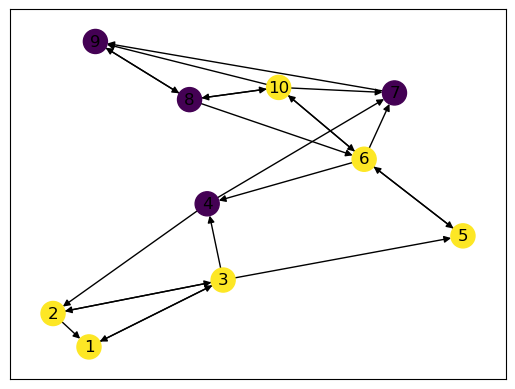

In [4]:
cmap = {
    -1: 0.,
    1: 1
}
opinions = nx.get_node_attributes(graph, name=OPINION_KEY)
nx.draw_networkx(graph, node_color=[opinions[node] for node in graph.nodes()])

In [5]:
graph, s, it = balance_opinions(graph, OPINION_KEY, SUGGESTABILITY_KEY)

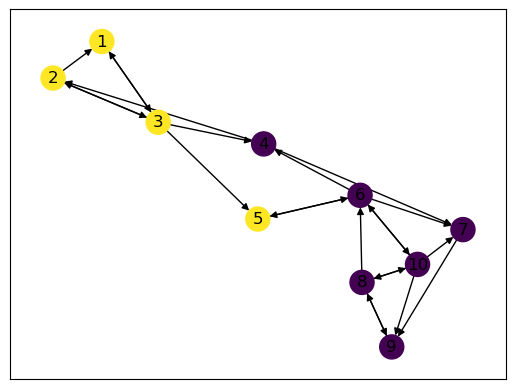

In [6]:
opinions = nx.get_node_attributes(graph, name=OPINION_KEY)
nx.draw_networkx(graph, node_color=[opinions[node] for node in graph.nodes()])

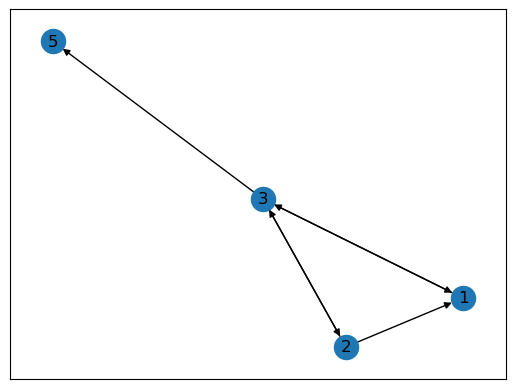

In [7]:
n, o = np.array([(node, opinions[node]) for node in graph.nodes()]).T
nx.draw_networkx(graph.subgraph(n[o == Opinion.plus_sigma]))

In [8]:
for s in seeds:
    break

In [10]:
type(s)

numpy.int64

# Расчет данных

In [2]:
# расчет данных
seed = 42
n_nodes = 1000
# avg_k = 10.02
avg_k = 3.93
p = avg_k / n_nodes
seed = 20160
f = 0.4
n_newtworks = 1000
np.random.seed(seed)
seeds = np.random.randint(1, 100005, size=int(n_newtworks * 1.1))

networks = []
ks = []
data = []
for s in tqdm(seeds):
    G = generate_er_graph(n_nodes, avg_k, f, BASE_SUGGESTABILITY, one_component=True, keep_n_nodes=False, seed=int(s))
    if len(G) < 10:
        continue

    networks.append(G)
    # ks.append(average_k(G))
    data.append(describe_graph(G))
    if len(networks) >= n_newtworks:
        break

graph_stat = pd.DataFrame(data)

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1023/1100 [00:53<00:04, 19.05it/s]


<AxesSubplot:xlabel='avg_k', ylabel='Count'>

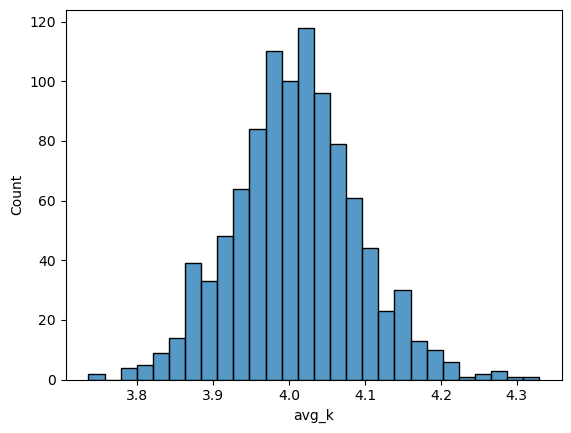

In [3]:
sns.histplot(graph_stat.avg_k)

In [4]:
graph_stat.describe(percentiles=[])

nodes  n_components        avg_k     fraction           s1  \
count  1000.000000        1000.0  1000.000000  1000.000000  1000.000000   
mean    978.741000           1.0     4.009100     0.400187     0.251600   
std       5.130716           0.0     0.083011     0.015711     0.038211   
min     961.000000           1.0     3.735926     0.350823     0.073022   
50%     979.000000           1.0     4.008167     0.400000     0.255242   
max     992.000000           1.0     4.329626     0.455579     0.342975   

                s2  
count  1000.000000  
mean      0.010383  
std       0.008045  
min       0.003043  
50%       0.008180  
max       0.108961

In [5]:
graph_stat.avg_k.mean()

4.009100192439549

In [48]:
from collections import defaultdict
from tqdm import tqdm

data = []
for sug in tqdm([4, 6, 8, 10]):
    for f in np.linspace(0, 0.5, 10):
        for G in networks:
            opinions = generate_opinions(G, f)
            nx.set_node_attributes(G, opinions, name=OPINION_KEY)
            nx.set_node_attributes(G, sug, name=SUGGESTABILITY_KEY)
            G, stable, _ = balance_opinions(G)
            d = describe_graph(G)
            d['f'] = f
            d['sug'] = sug
            data.append(d)
data = pd.DataFrame(data)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [31:22<00:00, 470.59s/it]


In [56]:
data.to_csv('experiment_data_k10.csv')

In [26]:
data.avg_k.mean()

4.009100192439549

In [2]:
try:
    data
except NameError:
    data = pd.read_csv('experiment_data.csv')

In [34]:
def process_data(data: pd.DataFrame):
    gr_data = data[['f', 'sug', 'fraction', 's1', 's2']].groupby(['sug', 'f'])
    description = gr_data.describe()

    result = pd.DataFrame(index=description.index)
    for col in ['fraction', 's1', 's2']:
        result[f'{col}_mean'] = gr_data[col].mean()
        result[f'{col}_std'] = gr_data[col].std()
    return result

In [35]:
result = process_data(data)

In [30]:
result.tail()

fraction_mean  fraction_std   s1_mean    s1_std   s2_mean  \
sug f                                                                     
8.0 0.555556       0.554986      0.015229  0.476581  0.023815  0.004404   
    0.666667       0.666164      0.015092  0.616994  0.020746  0.003218   
    0.777778       0.777743      0.012973  0.750491  0.016200  0.002477   
    0.888889       0.889566      0.009913  0.878226  0.011663  0.001764   
    1.000000       1.000000      0.000000  1.000000  0.000000  0.000000   

                s2_std  
sug f                   
8.0 0.555556  0.001635  
    0.666667  0.001214  
    0.777778  0.000887  
    0.888889  0.000741  
    1.000000  0.000000

### Графики

#### Для одного suggestability

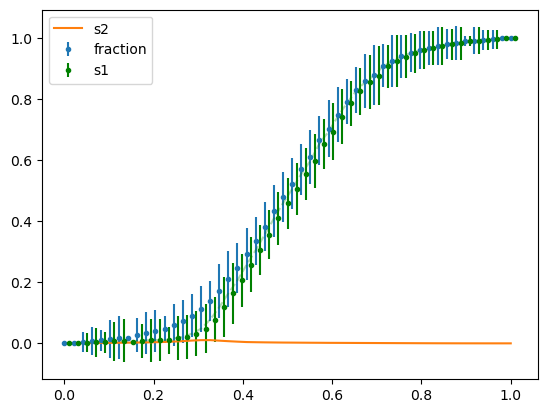

In [7]:
plt.figure()
plt.errorbar(result.index, result.fraction_mean, fmt='.', yerr=result.fraction_std, label='fraction')
plt.errorbar(result.index + np.diff(result.index).max()/2, result.s1_mean, fmt='.g', yerr=result.s1_std, label='s1')
plt.plot(result.index, result.s1_mean, '--g', alpha=.3)
plt.plot(result.index, result.s2_mean, label='s2')
plt.legend()

In [8]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

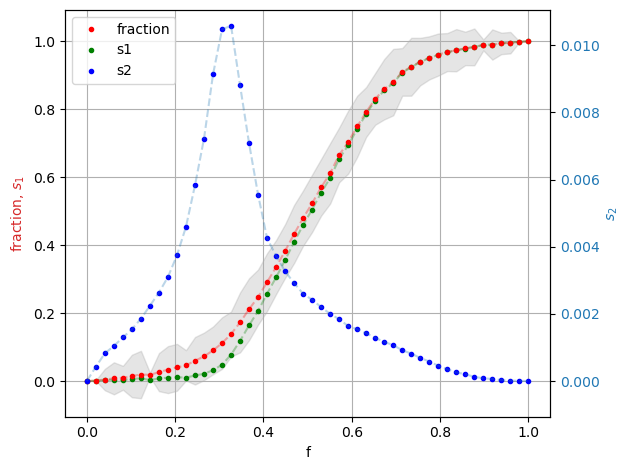

In [20]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('f')
ax1.set_ylabel('fraction, $s_1$', color=color)
plt.grid(True)

# ax1.errorbar(result.index, result.fraction_mean, fmt='r.', yerr=result.fraction_std, alpha=0.3, label='fraction')
# ax1.errorbar(result.index, result.s1_mean, fmt='.g', yerr=result.s1_std, label='s1')
ax1.plot(result.index, result.fraction_mean, '--r', alpha=0.3)
ax1.fill_between(result.index, result.fraction_mean - result.fraction_std, result.fraction_mean + result.fraction_std,
                 color='gray', alpha=0.2)

lns2 = ax1.plot(result.index, result.s1_mean, '.g', label='s1')
ax1.plot(result.index, result.s1_mean, '--g', alpha=0.3)

lns1 = ax1.plot(result.index, result.fraction_mean, '.r', label='fraction')
# ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('$s_2$', color=color)  # we already handled the x-label with ax1
lns3 = ax2.plot(result.index, result.s2_mean, '.b', label='s2')
ax2.plot(result.index, result.s2_mean, '--', alpha=0.3)
# ax2.errorbar(result.index, result.s2_mean, fmt='.', color=color, yerr=result.s2_std, label='s2')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ybound(upper=result.s2_mean.max() + 0.001)

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
align_yaxis(ax1, 0, ax2, 0)
plt.savefig('fraction_s1_s2.png')
plt.show()

In [ ]:
graph, stable, n_iters = balance_opinions(G, OPINION_KEY, SUGGESTABILITY_KEY)

In [ ]:
stable, n_iters

(True, 3)

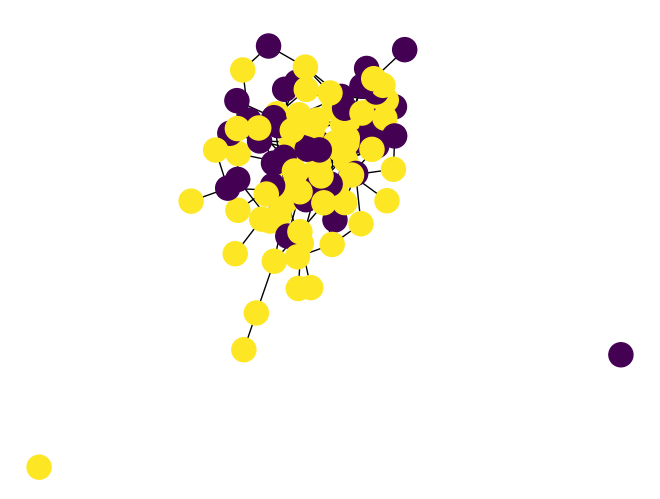

In [ ]:
pos = nx.spring_layout(G, seed=42)  # Seed for reproducible layout
nx.draw(graph, pos=pos, node_color=[opinions[node] for node in G.nodes()])
plt.show()

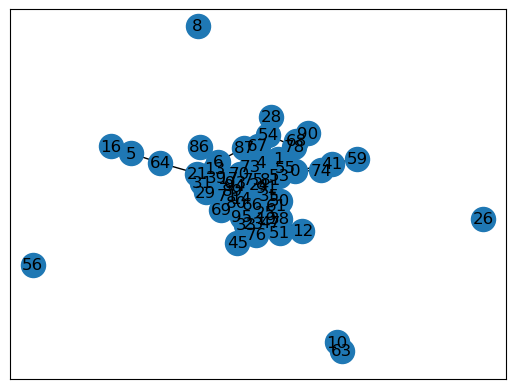

In [7]:
G = networks[0]
opinions = nx.get_node_attributes(G, name=OPINION_KEY)
n, o = np.array([(node, opinions[node]) for node in G.nodes()]).T
nx.draw_networkx(G.subgraph(n[o == Opinion.plus_sigma]))

In [ ]:
[len(g) for g in nx.connected_components(graph.subgraph(n[o == Opinion.plus_sigma]))], [len(g) for g in nx.connected_components(graph.subgraph(n[o == Opinion.minus_sigma]))]

([52, 1, 1, 4, 1, 1, 1, 1, 1],
 [10, 9, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [10]:
list(zip(*opinions.items()))

[(0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99),
 (1,
  1,
  -1,
  -1,
  1,
  1,
  1,
  -1,
  1,
  -1,
  1,
  -1,
  1,
  1,
  1,
  -1,
  1,
  1,
  -1,
  1,
  -1,
  1,
  -1,
  1,
  1,
  1,
  1,
  -1,
  1,
  1,
  -1,
  1,
  -1,
  1,
  -1,
  1,
  -1,
  -1,
  1,
  1,
  -1,
  1,
  -1,
  -1,
  -1,
  1,
  -1,
  1,
  -1,
  -1,
  1,
  1,
  -1,
  1,
  1,
  1,
  1,
  -1,
  -1,
  1,
  -1,
  1,
  -1,
  1,
  1,
  -1,
  1,
  1,
  1,
  1,
  1,
  1,
  -1,
  1,
  1,
  1,


#### Графики с разной убеждаемостью

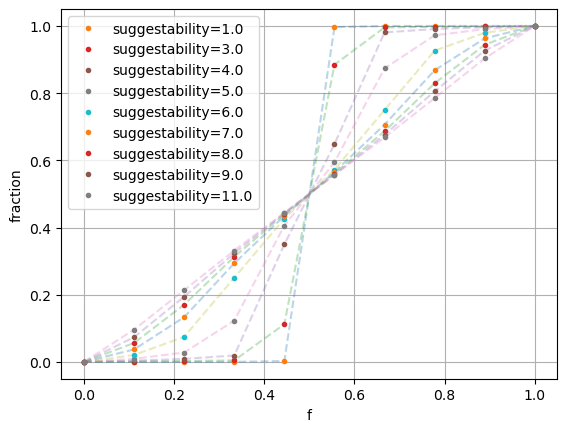

In [22]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('f')
ax1.set_ylabel('fraction')
plt.grid(True)

for suggestability in result.index.get_level_values(0).unique():
    r1 = result.loc[suggestability]
    ax1.plot(r1.index, r1.fraction_mean, '--', alpha=0.3)
    ax1.plot(r1.index, r1.fraction_mean, '.', label=f'{suggestability=}')

plt.legend()
plt.savefig('diff_suggest.png')

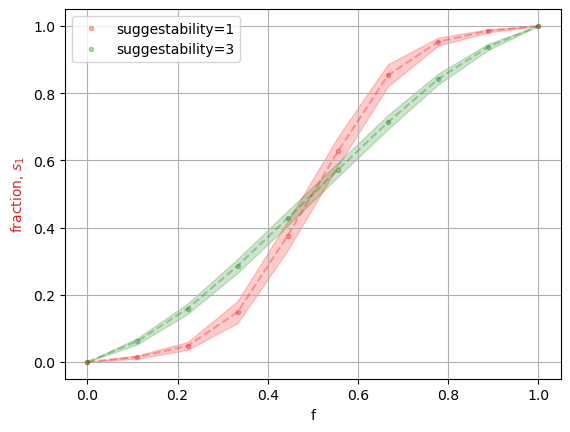

In [65]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('f')
ax1.set_ylabel('fraction, $s_1$', color=color)
plt.grid(True)

# ax1.errorbar(result.index, result.fraction_mean, fmt='r.', yerr=result.fraction_std, alpha=0.3, label='fraction')
# ax1.errorbar(result.index, result.s1_mean, fmt='.g', yerr=result.s1_std, label='s1')
ax1.plot(r1.index, r1.fraction_mean, '--r', alpha=0.3)
ax1.fill_between(r1.index, r1.fraction_mean - r1.fraction_std, r1.fraction_mean + r1.fraction_std,
                 color='red', alpha=0.2)

ax1.plot(r2.index, r2.fraction_mean, '--g', alpha=0.3)
ax1.fill_between(r2.index, r2.fraction_mean - r2.fraction_std, r2.fraction_mean + r2.fraction_std,
                 color='green', alpha=0.2)

ax1.plot(r1.index, r1.fraction_mean, '.r', alpha=0.3, label='suggestability=1')
ax1.plot(r2.index, r2.fraction_mean, '.g', alpha=0.3, label='suggestability=3')
plt.legend()
# lns1 = ax1.plot(result.index, result.fraction_mean, '.r', label='fraction')
# ax1.tick_params(axis='y', labelcolor=color)
plt.show()

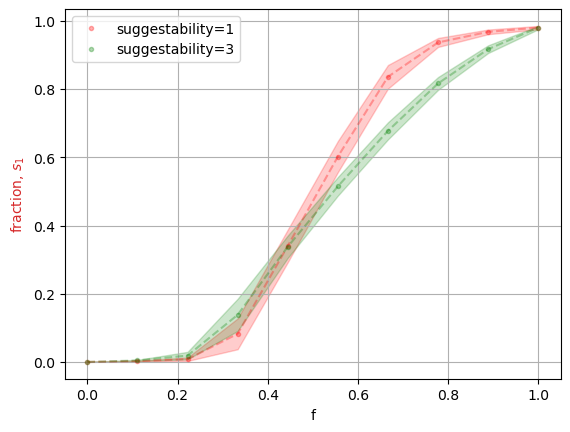

In [56]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('f')
ax1.set_ylabel('fraction, $s_1$', color=color)
plt.grid(True)

# ax1.errorbar(result.index, result.fraction_mean, fmt='r.', yerr=result.fraction_std, alpha=0.3, label='fraction')
# ax1.errorbar(result.index, result.s1_mean, fmt='.g', yerr=result.s1_std, label='s1')
ax1.plot(r1.f, r1.s1_mean, '--r', alpha=0.3)
ax1.fill_between(r1.f, r1.s1_mean - r1.s1_std, r1.s1_mean + r1.s1_std,
                 color='red', alpha=0.2)

ax1.plot(r2.f, r2.s1_mean, '--g', alpha=0.3)
ax1.fill_between(r2.f, r2.s1_mean - r2.s1_std, r2.s1_mean + r2.s1_std,
                 color='green', alpha=0.2)

ax1.plot(r1.f, r1.s1_mean, '.r', alpha=0.3, label='suggestability=1')
ax1.plot(r2.f, r2.s1_mean, '.g', alpha=0.3, label='suggestability=3')
plt.legend()
# lns1 = ax1.plot(result.index, result.fraction_mean, '.r', label='fraction')
# ax1.tick_params(axis='y', labelcolor=color)
plt.show()

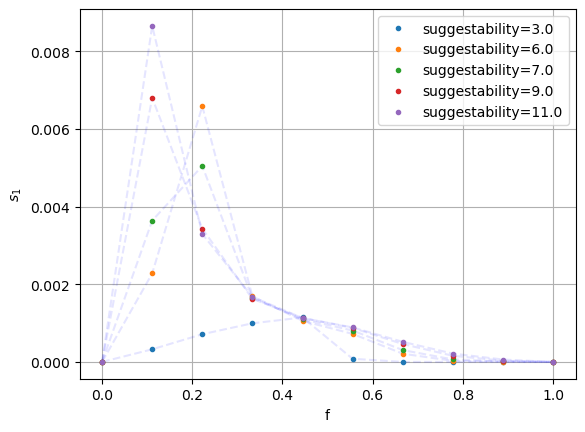

In [29]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('f')
ax1.set_ylabel('$s_1$')
plt.grid(True)

for suggestability in [3.0, 6.0, 7.0, 9.0, 11.0]: # result.index.get_level_values(0).unique():
    r1 = result.loc[suggestability]
    ax1.plot(r1.index, r1.s2_mean, 'b--', alpha=0.1)
    ax1.plot(r1.index, r1.s2_mean, '.', label=f'{suggestability=}')
ax1.legend()
plt.savefig('diff_suggest_s2.png')

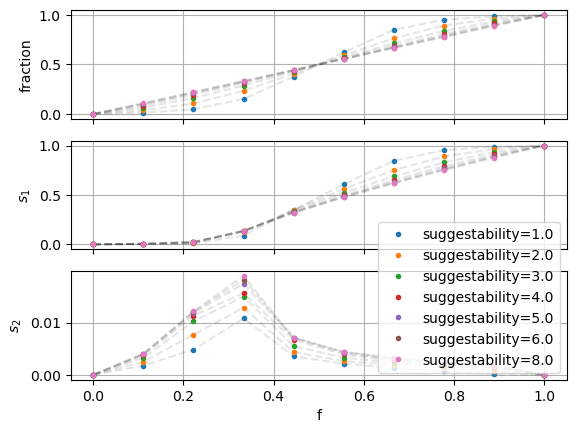

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

# colors = 'rgbm'
labels = ['fraction', '$s_1$', '$s_2$']

for suggestability in result.index.get_level_values(0).unique():
    r1 = result.loc[suggestability]
    ax1.plot(r1.index, r1.fraction_mean, 'k--', alpha=0.1)
    ax1.plot(r1.index, r1.fraction_mean, '.', label=f'{suggestability=}')
    
    ax2.plot(r1.index, r1.s1_mean, 'k--', alpha=0.1)
    ax2.plot(r1.index, r1.s1_mean, '.', label=f'{suggestability=}')
    
    ax3.plot(r1.index, r1.s2_mean, 'k--', alpha=0.1)
    ax3.plot(r1.index, r1.s2_mean, '.', label=f'{suggestability=}')

ax3.set_xlabel('f')
for l, ax in zip(labels, (ax1, ax2, ax3)):
    ax.set_ylabel(l)
    ax.grid(True)
    # ax.axis('equal')

ax3.legend()
plt.savefig('diff_suggest_k4.png')

In [57]:
k4 = process_data(pd.read_csv('experiment_data_k4.csv'))
k10 = process_data(pd.read_csv('experiment_data_k10.csv'))

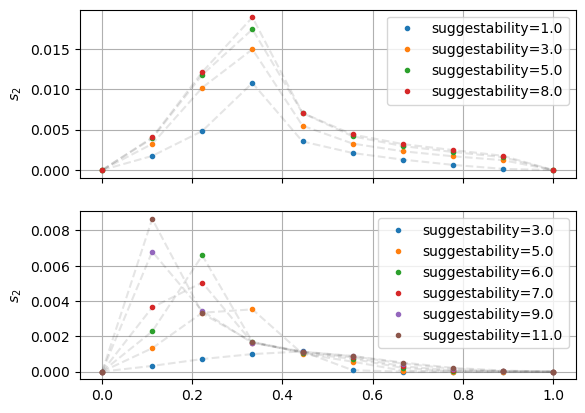

In [64]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# colors = 'rgbm'
labels = ['$s_2$', '$s_2$']

for suggestability in result.index.get_level_values(0).unique():
    if suggestability in [2., 4., 6.]: continue
    r1 = k4.loc[suggestability]
    ax1.plot(r1.index, r1.s2_mean, 'k--', alpha=0.1)
    ax1.plot(r1.index, r1.s2_mean, '.', label=f'{suggestability=}')

for suggestability in k10.index.get_level_values(0).unique():
    if suggestability in [1., 4., 8., 10.]: continue
    r1 = k10.loc[suggestability]
    ax2.plot(r1.index, r1.s2_mean, 'k--', alpha=0.1)
    ax2.plot(r1.index, r1.s2_mean, '.', label=f'{suggestability=}')

ax3.set_xlabel('f')
for l, ax in zip(labels, (ax1, ax2)):
    ax.set_ylabel(l)
    ax.grid(True)
    # ax.axis('equal')

ax1.legend()
ax2.legend()
plt.savefig('diff_suggest_s2_k410.png')

# Посчитанные данные для $\left<k\right>=4,\,8,\,12,\,16$

In [2]:
def load_data(path: str, processed: bool = True):
    file = 'processed.csv' if processed else 'raw.csv'
    index_col = 0 if processed else None
    return pd.read_csv(os.path.join(path, file), index_col=index_col)

In [3]:
k4_full_data = load_data('data/full/full_erd_ren_k4_n2000')
k12_full_data = load_data('data/full/full_erd_ren_k12_n2000')

In [4]:
k4_data = load_data('data/erd_ren_k4_n2000')
k8_data = load_data('data/erd_ren_k8_n2000')
k12_data = load_data('data/erd_ren_k12_n2000')
k16_data = load_data('data/erd_ren_k16_n2000')

ab_m2_data = load_data('data/bar_alb_k4_n2000/')
ab_m4_data = load_data('data/bar_alb_k8_n2000/')
ab_m6_data = load_data('data/bar_alb_k12_n2000/')
ab_m8_data = load_data('data/bar_alb_k16_n2000/')

rr_d4_data = load_data('data/random_regular_k4_n2000/')
rr_d8_data = load_data('data/random_regular_k8_n2000/')
rr_d12_data = load_data('data/random_regular_k12_n2000/')
rr_d16_data = load_data('data/random_regular_k16_n2000/')

sb_k4_data = load_data('data/stochastic_block_k4_n2000/')
sb_k8_data = load_data('data/stochastic_block_k8_n2000/')
sb_k12_data = load_data('data/stochastic_block_k12_n2000/')
sb_k16_data = load_data('data/stochastic_block_k16_n2000/')

## Графики

### Влияние убеждаемости

In [6]:
k4_full_data.head()

f  byzantine_prob  fraction_mean  fraction_std  \
sug                                                          
1    0.000000               0       0.000000      0.000000   
1    0.111111               0       0.013426      0.004758   
1    0.222222               0       0.047686      0.012703   
1    0.333333               0       0.152733      0.032656   
1    0.444444               0       0.374407      0.042959   

     n_minus_components_mean  n_minus_components_std   s1_mean    s1_std  \
sug                                                                        
1                     0.0000                0.000000  0.000000  0.000000   
1                    10.2040                3.237688  0.002632  0.001217   
1                    24.2635                4.828740  0.008833  0.005597   
1                    31.6530                6.207484  0.089050  0.045238   
1                    22.7270                5.359462  0.344608  0.047798   

      s2_mean    s2_std  stable_mean  stable_std  s1_persistence_mean  \
sug                                                                     
1    0.000000  0.000000          1.0         0.0                  NaN   
1    0.001778  0.000693          1.0         0.0             0.900662   
1    0.005014  0.002146          1.0         0.0             0.818395   
1    0.010658  0.007294          1.0         0.0             0.783756   
1    0.003586  0.001562          1.0         0.0             0.826477   

     s1_persistence_std  s2_persistence_mean  s2_persistence_std  \
sug                                                                
1                   NaN                  NaN                 NaN   
1              0.208390             0.903500            0.245095   
1              0.151106             0.817420            0.191735   
1              0.055525             0.782775            0.157643   
1              0.022362             0.821560            0.221633   

     s1_change_op_mean  s1_change_op_std  s2_change_op_mean  s2_change_op_std  
sug                                                                            
1                  NaN               NaN                NaN               NaN  
1             0.098838          0.208028           0.096000          0.244781  
1             0.179367          0.150841           0.180444          0.191371  
1             0.212900          0.054786           0.214474          0.156055  
1             0.172803          0.022152           0.177340          0.221546

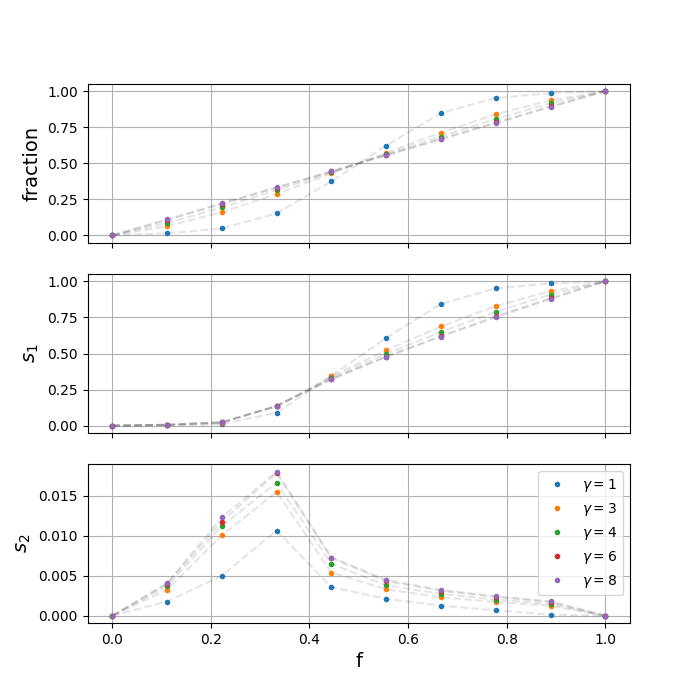

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 7), sharex=True)

# colors = 'rgbm'
labels = ['fraction', '$s_1$', '$s_2$']

for suggestability in k4_full_data.index.unique():
    r1 = k4_full_data.loc[suggestability]
    ax1.plot(r1.f, r1.fraction_mean, 'k--', alpha=0.1)
    ax1.plot(r1.f, r1.fraction_mean, '.', label=f'$\gamma={suggestability}$')
    
    ax2.plot(r1.f, r1.s1_mean, 'k--', alpha=0.1)
    ax2.plot(r1.f, r1.s1_mean, '.', label=f'$\gamma={suggestability}$')
    
    ax3.plot(r1.f, r1.s2_mean, 'k--', alpha=0.1)
    ax3.plot(r1.f, r1.s2_mean, '.', label=f'$\gamma={suggestability}$')

ax3.set_xlabel('f')
for l, ax in zip(labels, (ax1, ax2, ax3)):
    ax.set_ylabel(l)
    ax.grid(True)
    # ax.axis('equal')

ax3.legend()
plt.savefig('figures/diff_suggest_full_k4.png')
# plt.show()

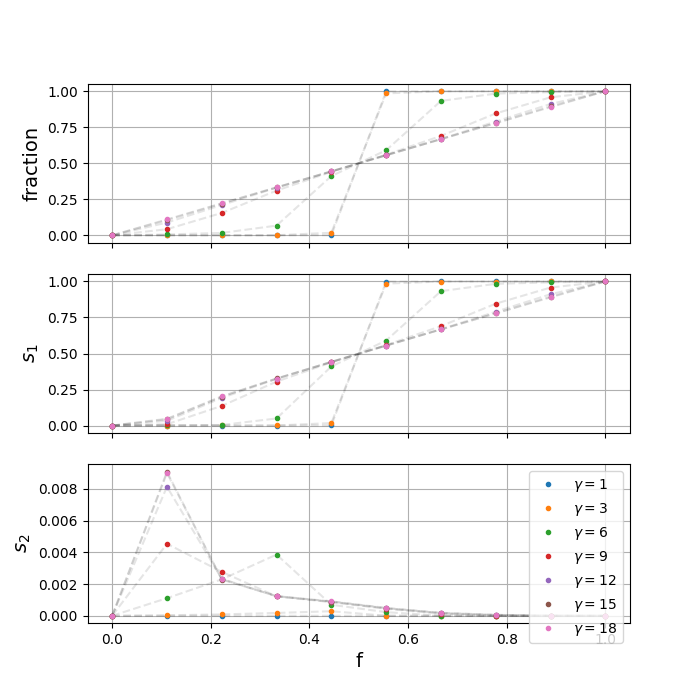

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 7), sharex=True)

# colors = 'rgbm'
labels = ['fraction', '$s_1$', '$s_2$']

for suggestability in k12_full_data.index.unique():
    r1 = k12_full_data.loc[suggestability]
    ax1.plot(r1.f, r1.fraction_mean, 'k--', alpha=0.1)
    ax1.plot(r1.f, r1.fraction_mean, '.', label=f'$\gamma={suggestability}$')
    
    ax2.plot(r1.f, r1.s1_mean, 'k--', alpha=0.1)
    ax2.plot(r1.f, r1.s1_mean, '.', label=f'$\gamma={suggestability}$')
    
    ax3.plot(r1.f, r1.s2_mean, 'k--', alpha=0.1)
    ax3.plot(r1.f, r1.s2_mean, '.', label=f'$\gamma={suggestability}$')

ax3.set_xlabel('f')
for l, ax in zip(labels, (ax1, ax2, ax3)):
    ax.set_ylabel(l)
    ax.grid(True)
    # ax.axis('equal')

ax3.legend()
plt.savefig('figures/diff_suggest_full_k12.png')
# plt.show()

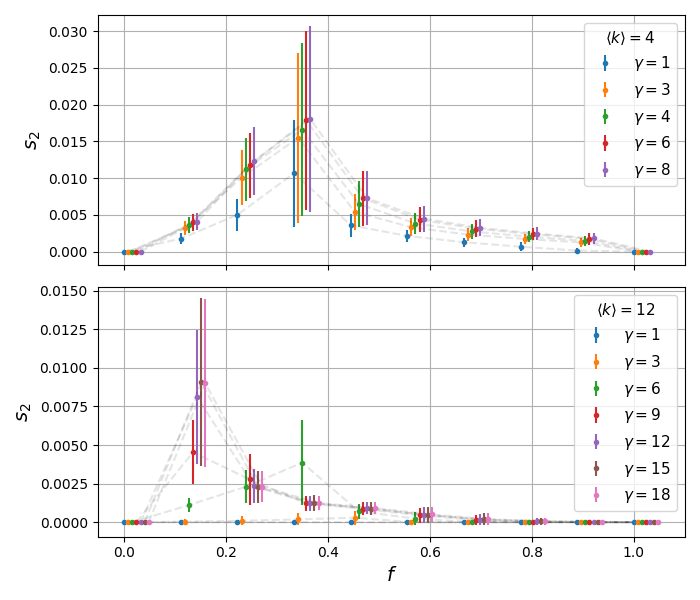

In [26]:
fig, axs = plt.subplots(2, 1, figsize=(7, 6), sharex=True)

delta = 8e-3

for ax, data, k in zip(axs, [k4_full_data, k12_full_data], [4, 12]):
    # ax.set_title(f'<k>={k}')
    for i, suggestability in enumerate(data.index.unique()):
        r1 = data.loc[suggestability]
        ax.plot(r1.f + i * delta, r1.s2_mean, 'k--', alpha=0.1)
        ax.errorbar(r1.f + i * delta, r1.s2_mean, yerr=r1.s2_std, fmt='.', label=f'$\gamma={suggestability}$')
    ax.set_ylabel('$s_2$')
    legend = ax.legend(fontsize=11)
    legend.set_title(f'$\\langle k\\rangle={k}$', prop={'size': 11})
    ax.grid(True)
ax.set_xlabel('$f$')
plt.tight_layout()
plt.savefig('figures/diff_suggest_s2_k412.png')

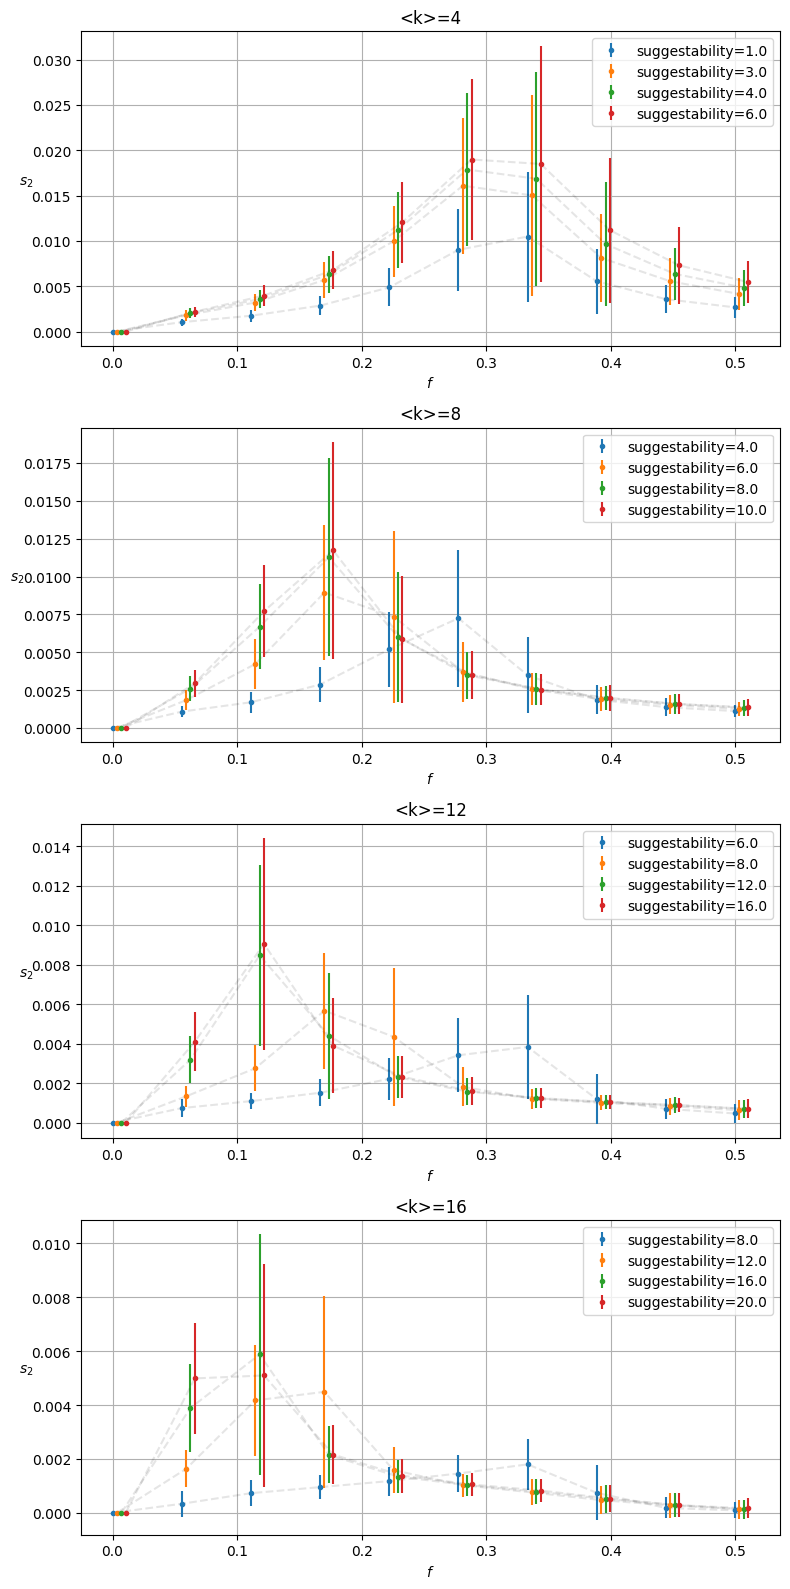

In [13]:
fig, axs = plt.subplots(4, 1, figsize=(8, 16))

for ax, data, k in zip(axs, [k4_data, k8_data, k12_data, k16_data], [4, 8, 12, 16]):
    ax.set_title(f'<k>={k}')
    for i, suggestability in enumerate(data.index.get_level_values(0).unique()):
        r1 = data.loc[suggestability]
        ax.plot(r1.f + i * 35e-4, r1.s2_mean, 'k--', alpha=0.1)
        # ax.plot(r1.f, r1.s2_mean, '.', label=f'{suggestability=}')
        ax.errorbar(r1.f + i * 35e-4, r1.s2_mean, yerr=r1.s2_std, fmt='.', label=f'{suggestability=}')
        # ax.fill_between(r1.f, r1.s2_mean - r1.s2_std, r1.s2_mean + r1.s2_std,
        #          color='grey', alpha=0.2)
    ax.set_xlabel('$f$')
    ax.set_ylabel('$s_2$', rotation=0)
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.savefig('figures/diff_suggest_s2.png')

In [ ]:
1, 3, 6, 8, 10, 13, 16, 22, 32

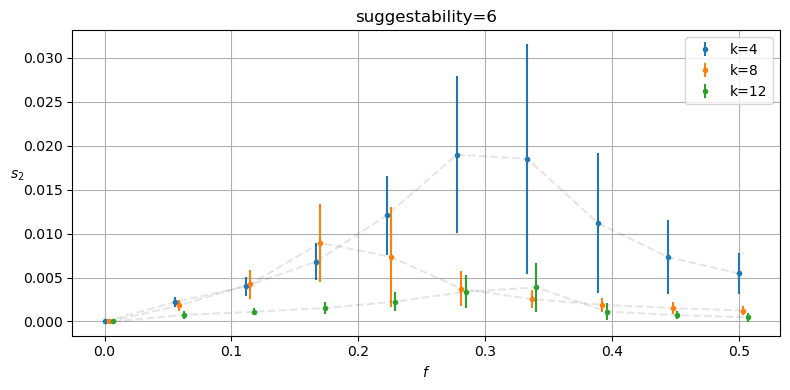

In [53]:
fig, ax = plt.subplots(figsize=(8, 4))

suggestability = 6

ax.set_title(f'{suggestability=}')
for i, (data, k) in enumerate(zip([k4_data, k8_data, k12_data], [4, 8, 12, 16])):
    r1 = data.loc[suggestability]
    ax.plot(r1.f + i * 35e-4, r1.s2_mean, 'k--', alpha=0.1)
    # ax.plot(r1.f, r1.s2_mean, '.', label=f'{suggestability=}')
    ax.errorbar(r1.f + i * 35e-4, r1.s2_mean, yerr=r1.s2_std, fmt='.', label=f'{k=}')
        # ax.fill_between(r1.f, r1.s2_mean - r1.s2_std, r1.s2_mean + r1.s2_std,
        #          color='grey', alpha=0.2)
    ax.set_xlabel('$f$')
    ax.set_ylabel('$s_2$', rotation=0)
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.savefig('figures/diff_suggest6_s2.png')

In [33]:
!PYTHONPATH=./ python scripts/evaluate_networks.py configs/config_k8.json y

Overwriting existing directory
Reading 2000 networks from directory networks/k=8
100%|███████████████████████████████████████| 2000/2000 [02:42<00:00, 12.33it/s]
Evaluating suggestability=4
100%|███████████████████████████████████████████| 10/10 [15:20<00:00, 92.09s/it]
Evaluating suggestability=6
100%|███████████████████████████████████████████| 10/10 [13:48<00:00, 82.86s/it]
Evaluating suggestability=8
100%|███████████████████████████████████████████| 10/10 [11:37<00:00, 69.75s/it]
Evaluating suggestability=10
100%|███████████████████████████████████████████| 10/10 [11:32<00:00, 69.27s/it]
Saving data into data/erd_ren_k8_n1000


In [34]:
!PYTHONPATH=./ python scripts/evaluate_networks.py configs/config_k16.json y

Overwriting existing directory
Reading 2000 networks from directory networks/k=16
100%|███████████████████████████████████████| 2000/2000 [07:06<00:00,  4.69it/s]
Evaluating suggestability=8
100%|██████████████████████████████████████████| 10/10 [24:14<00:00, 145.40s/it]
Evaluating suggestability=12
100%|██████████████████████████████████████████| 10/10 [22:12<00:00, 133.29s/it]
Evaluating suggestability=16
100%|██████████████████████████████████████████| 10/10 [20:09<00:00, 120.96s/it]
Evaluating suggestability=20
100%|██████████████████████████████████████████| 10/10 [18:59<00:00, 113.98s/it]
Saving data into data/erd_ren_k16_n1000


In [5]:
ab_m2_data = load_data('data/bar_alb_k4_n2000/')
ab_m4_data = load_data('data/bar_alb_k8_n2000/')
ab_m6_data = load_data('data/bar_alb_k12_n2000/')

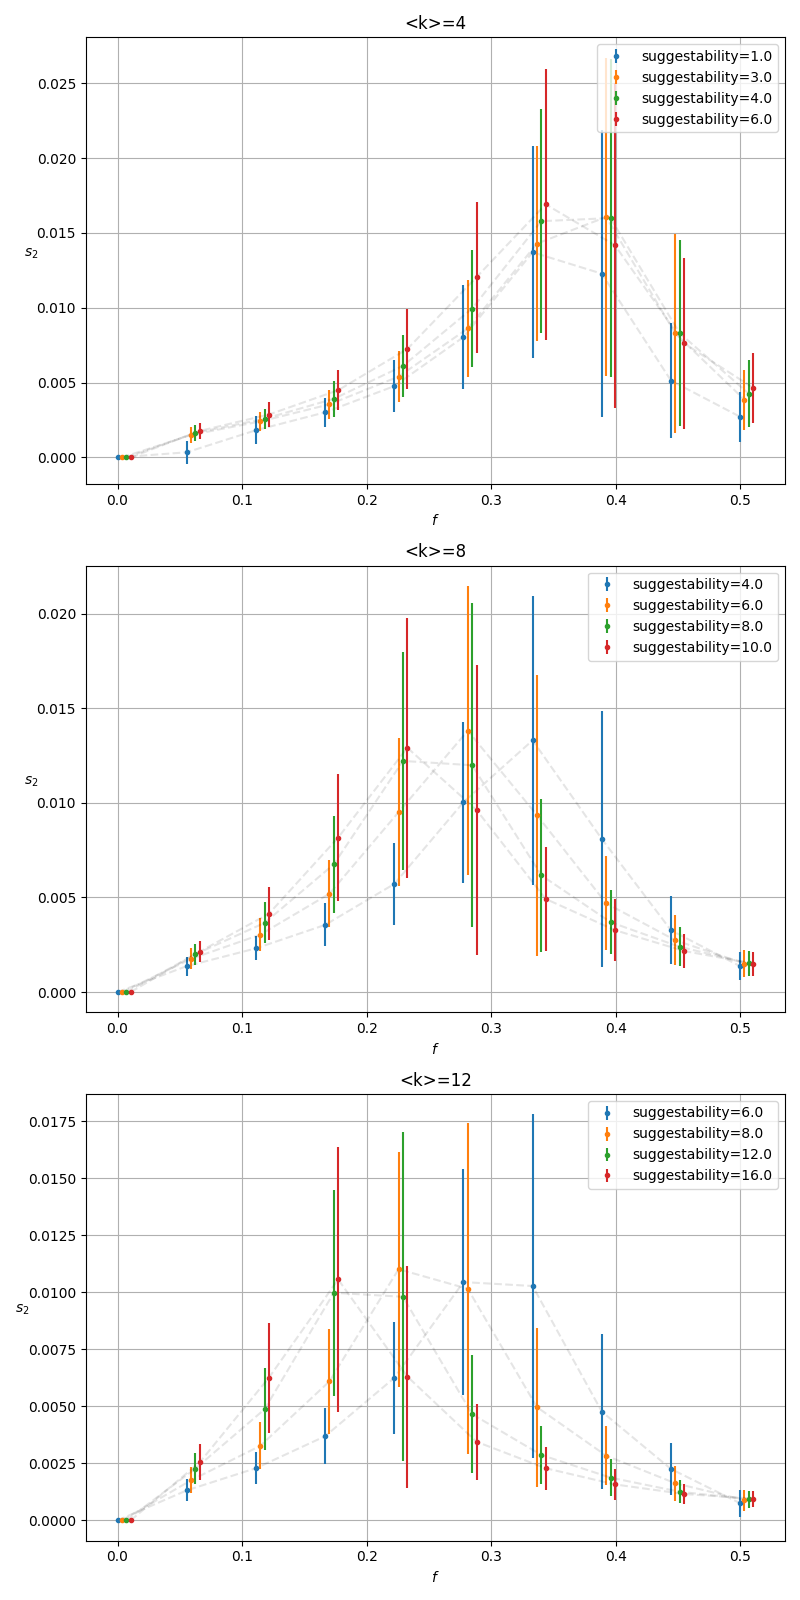

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(8, 16))

for ax, data, k in zip(axs, [ab_m2_data, ab_m4_data, ab_m6_data], [4, 8, 12]):
    ax.set_title(f'<k>={k}')
    for i, suggestability in enumerate(data.index.get_level_values(0).unique()):
        r1 = data.loc[suggestability]
        ax.plot(r1.f + i * 35e-4, r1.s2_mean, 'k--', alpha=0.1)
        # ax.plot(r1.f, r1.s2_mean, '.', label=f'{suggestability=}')
        ax.errorbar(r1.f + i * 35e-4, r1.s2_mean, yerr=r1.s2_std, fmt='.', label=f'{suggestability=}')
        # ax.fill_between(r1.f, r1.s2_mean - r1.s2_std, r1.s2_mean + r1.s2_std,
        #          color='grey', alpha=0.2)
    ax.set_xlabel('$f$')
    ax.set_ylabel('$s_2$', rotation=0)
    ax.legend()
    ax.grid(True)
plt.tight_layout()

In [9]:
ab_m4_data.describe()

f  fraction_mean  fraction_std    s1_mean     s1_std  \
count  40.000000      40.000000     40.000000  40.000000  40.000000   
mean    0.250000       0.140433      0.026132   0.099003   0.029047   
std     0.161604       0.170138      0.063806   0.165654   0.065074   
min     0.000000       0.000000      0.000000   0.000000   0.000000   
25%     0.111111       0.000009      0.000093   0.000009   0.000093   
50%     0.250000       0.062758      0.010823   0.007097   0.003573   
75%     0.388889       0.238526      0.021194   0.118577   0.038944   
max     0.500000       0.509454      0.394776   0.509452   0.394776   

         s2_mean     s2_std  
count  40.000000  40.000000  
mean    0.003543   0.001904  
std     0.004165   0.002487  
min     0.000000   0.000000  
25%     0.000000   0.000000  
50%     0.002037   0.000907  
75%     0.005373   0.002411  
max     0.014072   0.008021

In [10]:
ab_m4_data.index

Index([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0, 3.0,
       3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0,
       4.0, 4.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0],
      dtype='float64', name='sug')

### Разные сети

In [4]:
all_data = [
    [k4_data, k8_data, k12_data, k16_data],
    [ab_m2_data, ab_m4_data, ab_m6_data, ab_m8_data],
    [rr_d4_data, rr_d8_data, rr_d12_data, rr_d16_data],
    [sb_k4_data, sb_k8_data, sb_k12_data, sb_k16_data],
]

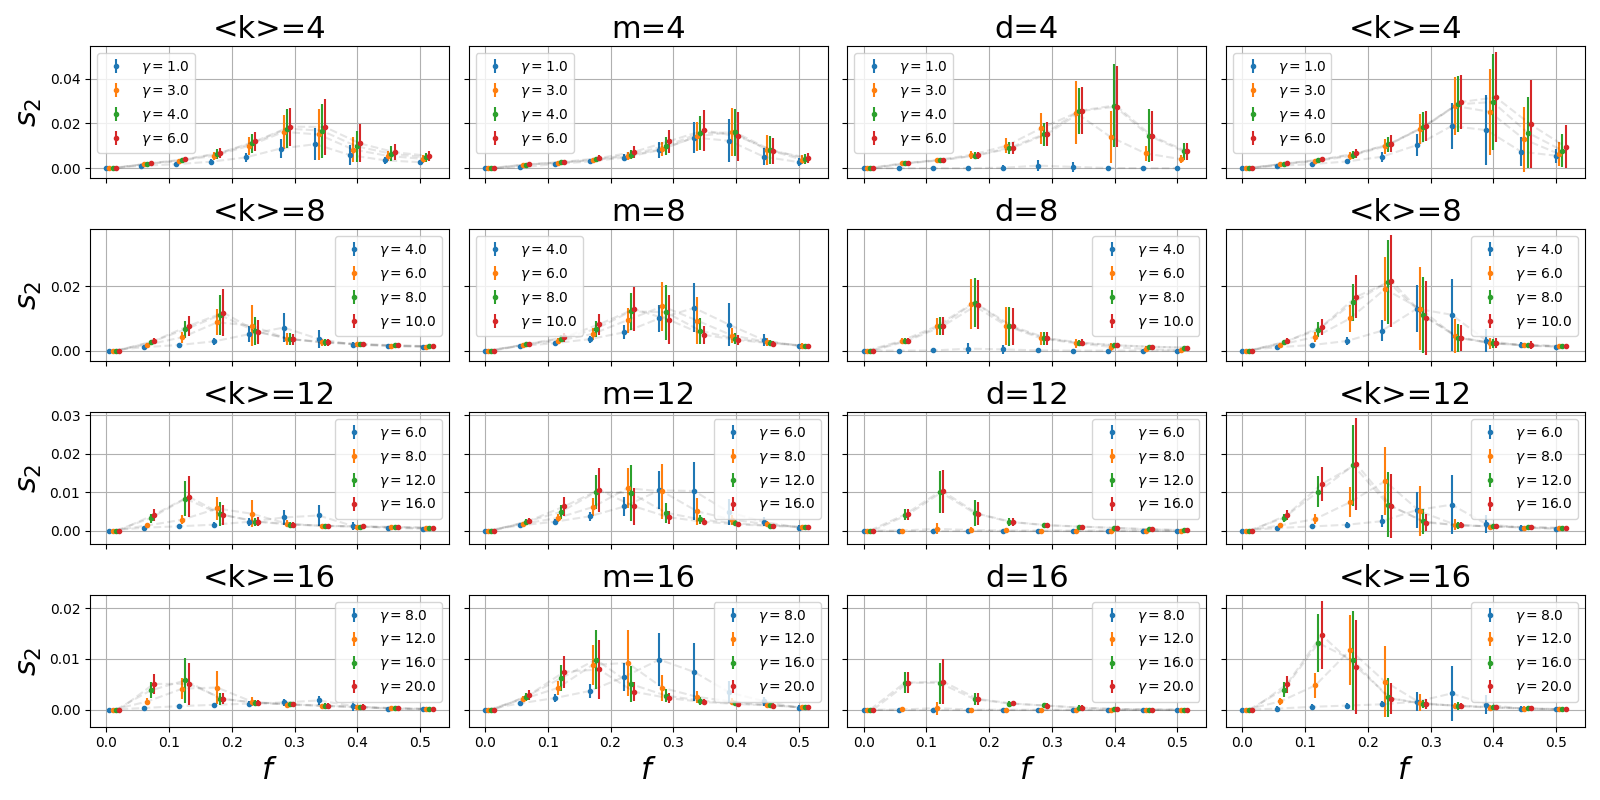

In [16]:
fig, all_axs = plt.subplots(4, 4, figsize=(16, 8), sharex=True, sharey='row')

prms = [
    [4, 8, 12, 16],
    [2, 4, 6, 8],
    [4, 8, 12, 16]
]

delta = 5e-3

for axs, full_data, symb in zip(all_axs.T, all_data, ['<k>', 'm', 'd', '<k>']):
    for ax, data, k in zip(axs, full_data, [4, 8, 12, 16]):
        ax.set_title(f'{symb}={k}', fontsize=22)
        for i, suggestability in enumerate(data.index.get_level_values(0).unique()):
            if symb == '<k>' and k > 4 and suggestability <= 2:
                continue
            r1 = data.loc[suggestability]
            ax.plot(r1.f + i * delta, r1.s2_mean, 'k--', alpha=0.1)
            ax.errorbar(r1.f + i * delta, r1.s2_mean, yerr=r1.s2_std, fmt='.', label=f'$\gamma={suggestability}$')
        ax.legend()
        ax.grid(True)
for ax in all_axs[:, 0]:
    ax.set_ylabel('$s_2$', fontsize=22)
for ax in all_axs[-1]:
    ax.set_xlabel('$f$', fontsize=22)
plt.tight_layout()
plt.savefig('figures/diff_suggest_s2_diff_network_struct.png')

## Persistence

In [5]:
ks = [4, 6, 8, 10, 12, 16]
all_dfs = []
for k in ks:
    df = load_data(f'data/diff_k/k{k}')
    df['k'] = k
    all_dfs.append(df)
diff_k_data = pd.concat(all_dfs)

In [6]:
diff_k_data.head(10)

f  byzantine_prob  fraction_mean  fraction_std  \
sug                                                      
1    0.28               0       0.080094      0.018767   
4    0.28               0       0.255134      0.016366   
8    0.28               0       0.279622      0.014561   
12   0.28               0       0.279655      0.014211   
16   0.28               0       0.279798      0.014422   
1    0.28               0       0.008063      0.004057   
4    0.28               0       0.201551      0.022272   
8    0.28               0       0.276768      0.014885   
12   0.28               0       0.279524      0.014506   
16   0.28               0       0.279665      0.014321   

     n_minus_components_mean  n_minus_components_std   s1_mean    s1_std  \
sug                                                                        
1                    31.3135                5.339707  0.018882  0.012985   
4                   107.1590               10.954164  0.058189  0.032528   
8                   121.4020               11.809917  0.060202  0.033244   
12                  121.6345               11.432290  0.058963  0.032391   
16                  121.6875               11.556670  0.060028  0.032858   
1                     5.5695                2.368961  0.002588  0.001606   
4                    47.2060                8.155294  0.128746  0.037762   
8                    64.5775                9.727040  0.186853  0.029422   
12                   65.9015                9.706900  0.188534  0.028522   
16                   66.4050                9.911160  0.187094  0.030018   

      s2_mean    s2_std  ...  stable_std  s1_persistence_mean  \
sug                      ...                                    
1    0.008492  0.004031  ...         0.0             0.759356   
4    0.017833  0.008579  ...         0.0             0.974685   
8    0.018698  0.008954  ...         0.0             0.999696   
12   0.019130  0.009078  ...         0.0             1.000000   
16   0.018593  0.008808  ...         0.0             1.000000   
1    0.001546  0.000754  ...         0.0             0.693900   
4    0.008525  0.006417  ...         0.0             0.920184   
8    0.007157  0.004676  ...         0.0             0.996558   
12   0.007318  0.005109  ...         0.0             0.999947   
16   0.007457  0.005300  ...         0.0             1.000000   

     s1_persistence_std  s2_persistence_mean  s2_persistence_std  \
sug                                                                
1              0.118255             0.756834            0.157504   
4              0.024671             0.975065            0.041791   
8              0.002554             0.999769            0.003820   
12             0.000000             1.000000            0.000000   
16             0.000000             1.000000            0.000000   
1              0.330059             0.692310            0.399705   
4              0.026109             0.916854            0.112125   
8              0.004356             0.996651            0.024055   
12             0.000542             0.999875            0.005590   
16             0.000000             1.000000            0.000000   

     s1_change_op_mean  s1_change_op_std  s2_change_op_mean  s2_change_op_std  \
sug                                                                             
1             0.217479          0.114490           0.219669          0.152766   
4             0.025315          0.024671           0.024935          0.041791   
8             0.000304          0.002554           0.000231          0.003820   
12            0.000000          0.000000           0.000000          0.000000   
16            0.000000          0.000000           0.000000          0.000000   
1             0.282594          0.321262           0.285891          0.389516   
4             0.079804          0.026094           0.083146          0.112125   
8             0.003442          0.004356           0.003349          0.

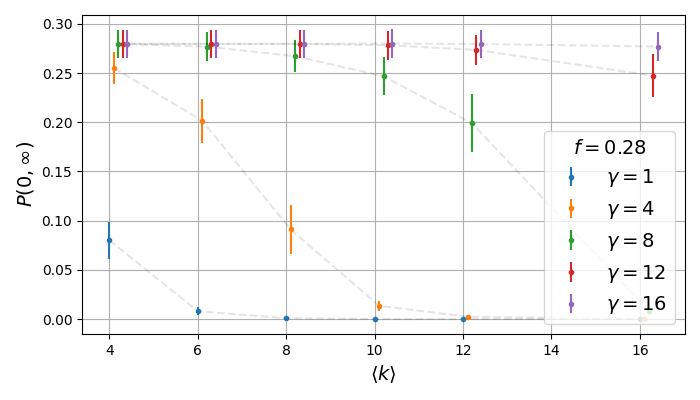

In [28]:
plt.close('s2_vs_k')
fig, ax = plt.subplots(figsize=(7, 4), num='s2_vs_k')

delta = 1e-1
for i, sug in enumerate(diff_k_data.index.unique()):
    data = diff_k_data.loc[sug]
    ax.plot(data.k + i * delta, data.fraction_mean, 'k--', alpha=0.1)
    # ax.plot(data.k + i * delta, data.s2_persistence_mean, '.', label=f'$\gamma={sug}$')
    ax.errorbar(data.k + i * delta, data.fraction_mean, yerr=data.fraction_std, fmt='.', label=f'$\gamma={sug}$')
ax.grid()
legend = ax.legend(loc='lower right', fontsize=14).set_title("$f=0.28$", prop={"size": 14})
ax.set_xlabel(r'$\langle k\rangle$')
ax.set_ylabel(r'$P(0, \infty)$', rotation=90)

plt.tight_layout()
plt.savefig('figures/s2_vs_k.png')

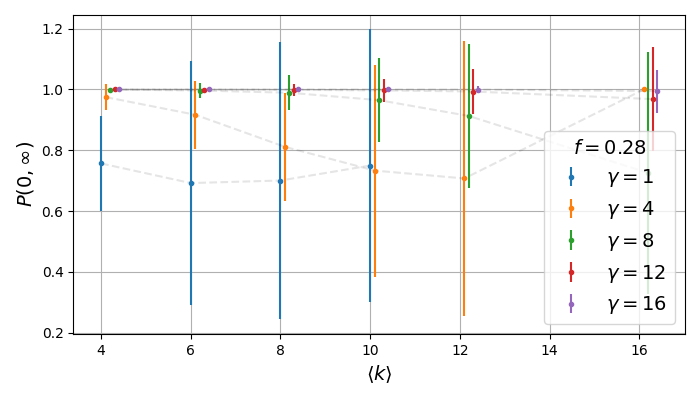

In [20]:
plt.close('s2_persistence')
fig, ax = plt.subplots(figsize=(7, 4), num='s2_persistence')

delta = 1e-1
for i, sug in enumerate(diff_k_data.index.unique()):
    data = diff_k_data.loc[sug]
    ax.plot(data.k + i * delta, data.s2_persistence_mean, 'k--', alpha=0.1)
    # ax.plot(data.k + i * delta, data.s2_persistence_mean, '.', label=f'$\gamma={sug}$')
    ax.errorbar(data.k + i * delta, data.s2_persistence_mean, yerr=data.s2_persistence_std, fmt='.', label=f'$\gamma={sug}$')
ax.grid()
legend = ax.legend(loc='lower right', fontsize=14).set_title("$f=0.28$", prop={"size": 14})
ax.set_xlabel(r'$\langle k\rangle$')
ax.set_ylabel(r'$P(0, \infty)$', rotation=90)

plt.tight_layout()
plt.savefig('figures/s2_persistence_vs_k.png')

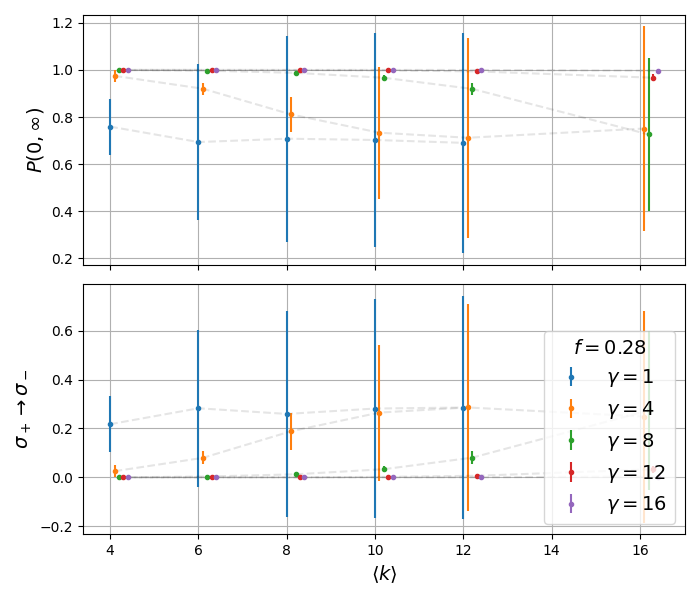

In [19]:
plt.close('s1_persistence')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 6), num='s1_persistence', sharex=True)

delta = 1e-1
for i, sug in enumerate(diff_k_data.index.unique()):
    data = diff_k_data.loc[sug]
    ax1.plot(data.k + i * delta, data.s1_persistence_mean, 'k--', alpha=0.1)
    # ax.plot(data.k + i * delta, data.s2_persistence_mean, '.', label=f'$\gamma={sug}$')
    ax1.errorbar(data.k + i * delta, data.s1_persistence_mean, yerr=data.s1_persistence_std, fmt='.', label=f'$\gamma={sug}$')
ax1.grid()
# legend = ax1.legend(loc='lower right', fontsize=14).set_title("$f=0.28$", prop={"size": 14})
ax1.set_ylabel('$P(0, \infty)$', rotation=90)


for i, sug in enumerate(diff_k_data.index.unique()):
    data = diff_k_data.loc[sug]
    ax2.plot(data.k + i * delta, data.s1_change_op_mean, 'k--', alpha=0.1)
    # ax.plot(data.k + i * delta, data.s2_persistence_mean, '.', label=f'$\gamma={sug}$')
    ax2.errorbar(data.k + i * delta, data.s1_change_op_mean, yerr=data.s1_change_op_std, fmt='.', label=f'$\gamma={sug}$')
ax2.grid()
legend = ax2.legend(loc='lower right', fontsize=14).set_title("$f=0.28$", prop={"size": 14})
ax2.set_ylabel('$\sigma_+\\to\sigma_-$', rotation=90)
ax2.set_xlabel(r'$\langle k\rangle$')

plt.tight_layout()
plt.savefig('figures/s1_persistence_sigma_change_vs_k.png')

In [10]:
legend = ax2.get_legend()

In [11]:
legend.set_loc('center right')

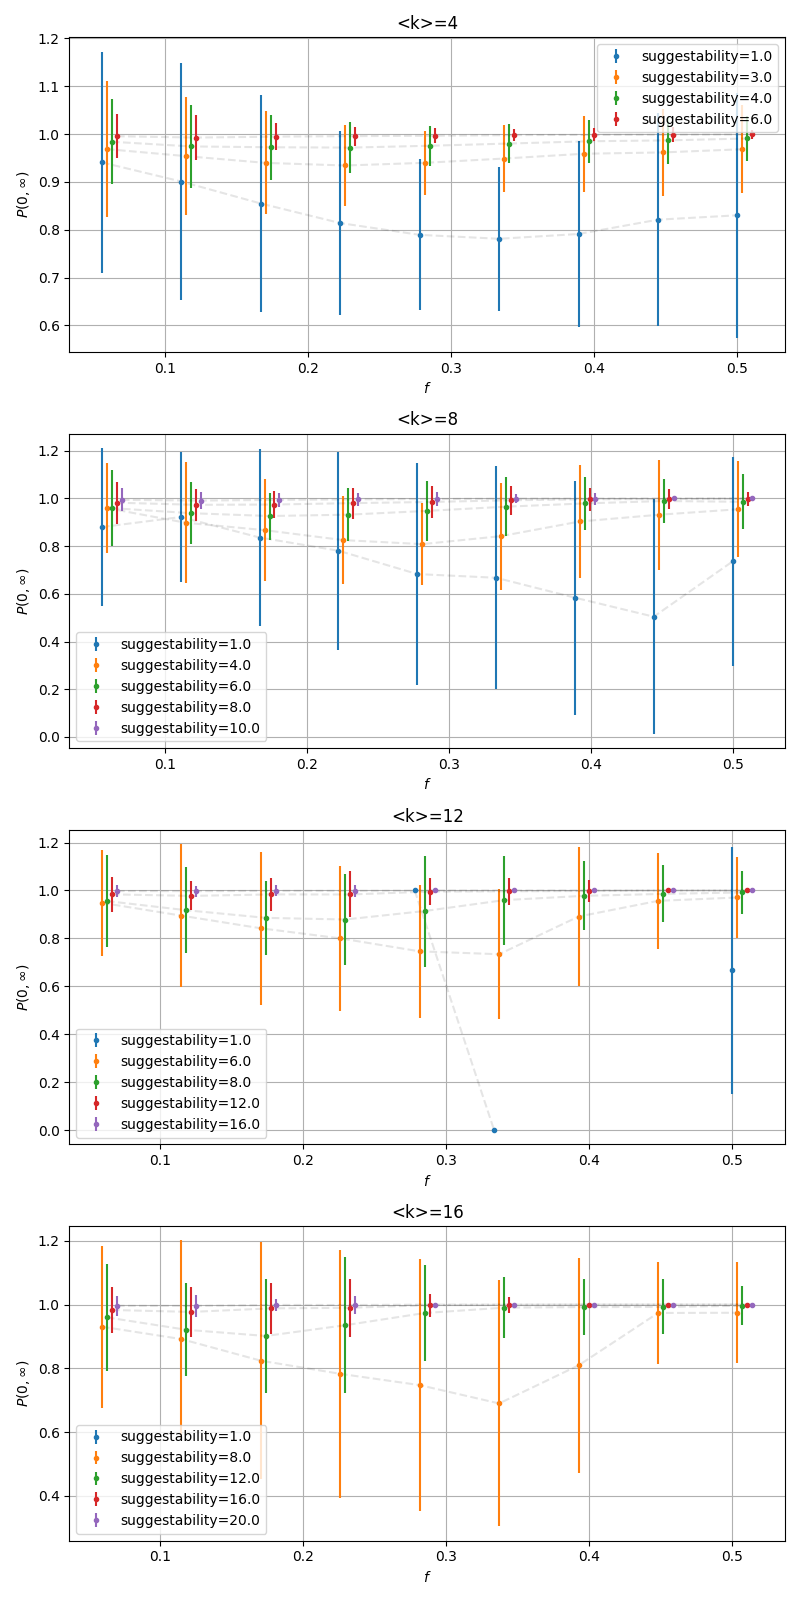

In [4]:
fig, axs = plt.subplots(4, 1, figsize=(8, 16))

for ax, data, k in zip(axs, [k4_data, k8_data, k12_data, k16_data], [4, 8, 12, 16]):
    ax.set_title(f'<k>={k}')
    for i, suggestability in enumerate(data.index.get_level_values(0).unique()):
        r1 = data.loc[suggestability]
        ax.plot(r1.f + i * 35e-4, r1.s2_persistence_mean, 'k--', alpha=0.1)
        ax.errorbar(r1.f + i * 35e-4, r1.s2_persistence_mean, yerr=r1.s2_persistence_std, fmt='.', label=f'{suggestability=}')
    
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.savefig('figures/erd_renyi_persistence_s2.png')

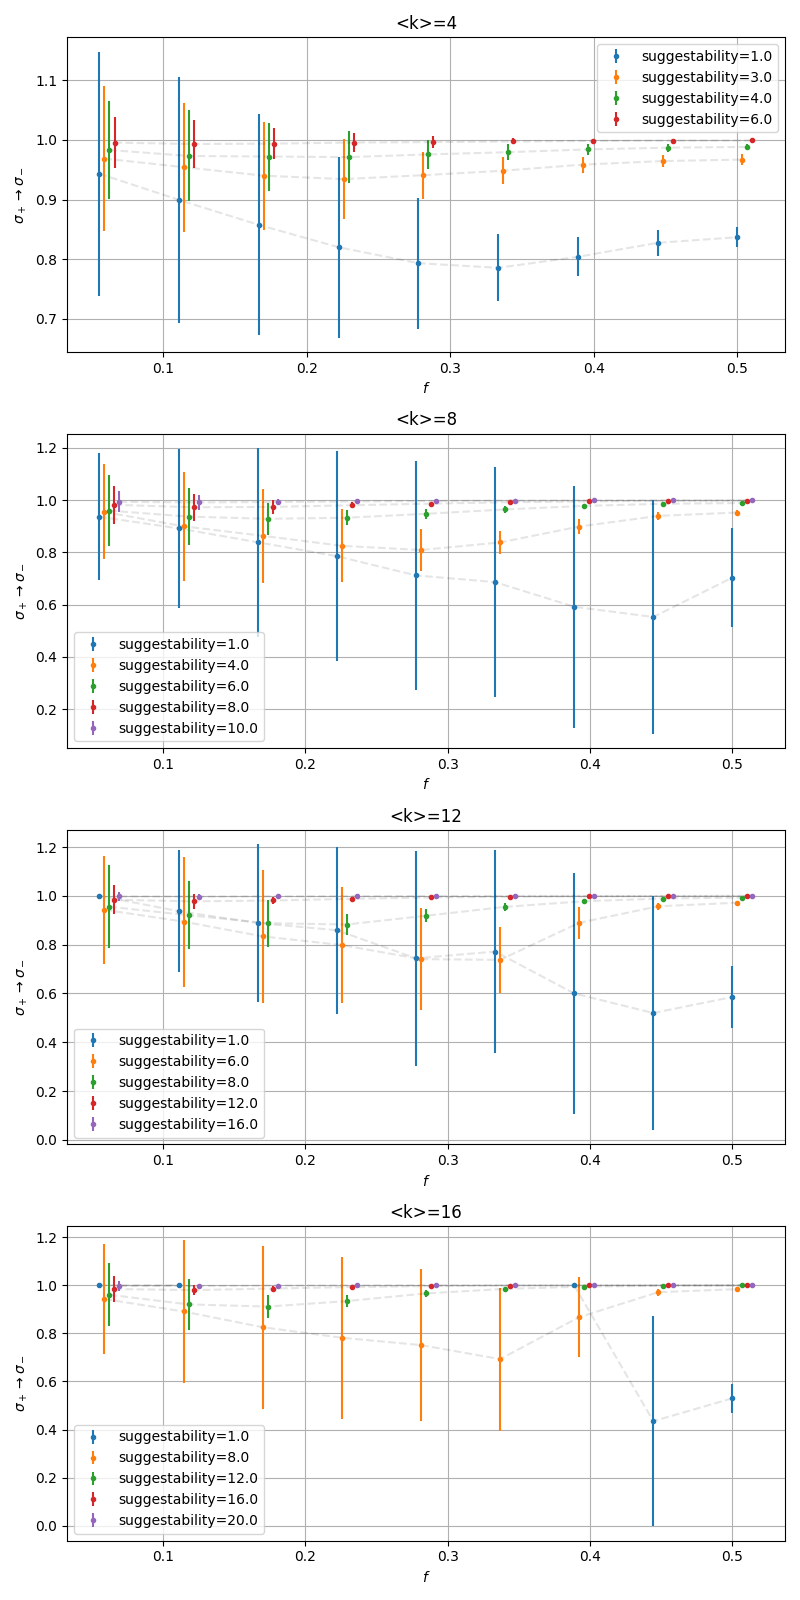

In [10]:
fig, axs = plt.subplots(4, 1, figsize=(8, 16))

COLUMN = 's1_change_op'
MEAN_COLUMN = COLUMN + '_mean'
STD_COLUMN = COLUMN + '_std'


for ax, data, k in zip(axs, [k4_data, k8_data, k12_data, k16_data], [4, 8, 12, 16]):
    ax.set_title(f'<k>={k}')
    for i, suggestability in enumerate(data.index.get_level_values(0).unique()):
        r1 = data.loc[suggestability]
        ax.plot(r1.f + i * 35e-4, 1 - r1[MEAN_COLUMN], 'k--', alpha=0.1)
        ax.errorbar(r1.f + i * 35e-4, 1 - r1[MEAN_COLUMN], yerr=r1[STD_COLUMN], fmt='.', label=f'{suggestability=}')
    ax.set_xlabel('$f$')
    ax.set_ylabel('$\sigma_+\\to\sigma_-$', rotation=90)
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.savefig('figures/plus_minus.png')

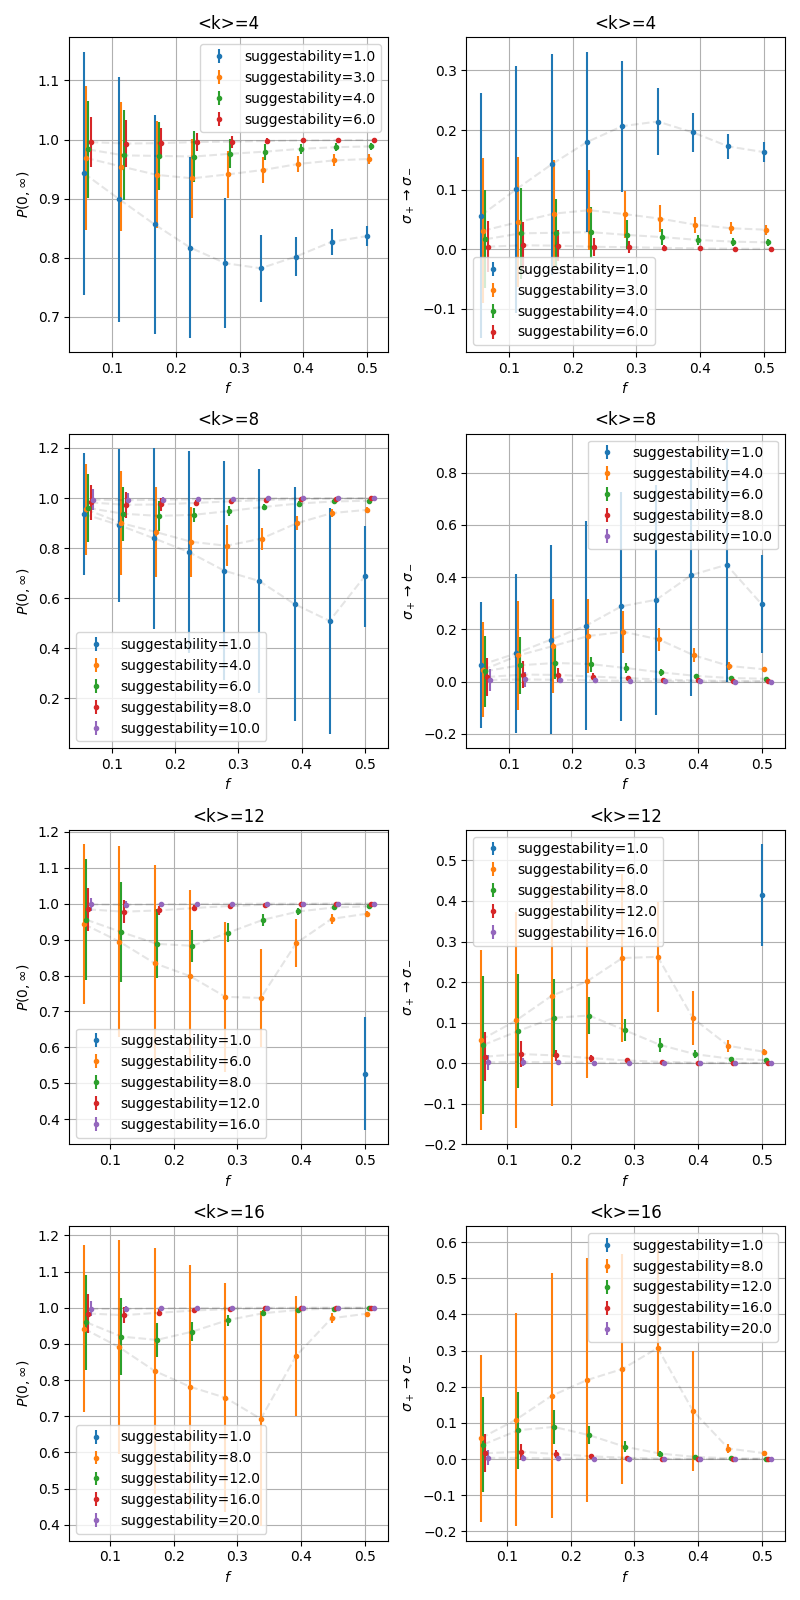

In [5]:
fig, axs = plt.subplots(4, 2, figsize=(8, 16), sharey=False)

COLUMN = 's1_change_op'
MEAN_COLUMN = COLUMN + '_mean'
STD_COLUMN = COLUMN + '_std'


for ax, data, k in zip(axs[:, 0], [k4_data, k8_data, k12_data, k16_data], [4, 8, 12, 16]):
    ax.set_title(f'<k>={k}')
    for i, suggestability in enumerate(data.index.get_level_values(0).unique()):
        r1 = data.loc[suggestability].dropna()
        ax.plot(r1.f + i * 35e-4, r1.s1_persistence_mean, 'k--', alpha=0.1)
        ax.errorbar(r1.f + i * 35e-4, r1.s1_persistence_mean, yerr=r1.s1_persistence_std, fmt='.', label=f'{suggestability=}')
    ax.set_xlabel('$f$')
    ax.set_ylabel('$P(0, \infty)$', rotation=90)
    ax.legend()
    ax.grid(True)

for ax, data, k in zip(axs[:, 1], [k4_data, k8_data, k12_data, k16_data], [4, 8, 12, 16]):
    ax.set_title(f'<k>={k}')
    for i, suggestability in enumerate(data.index.get_level_values(0).unique()):
        r1 = data.loc[suggestability].dropna()
        ax.plot(r1.f + i * 35e-4, r1[MEAN_COLUMN], 'k--', alpha=0.1)
        ax.errorbar(r1.f + i * 35e-4, r1[MEAN_COLUMN], yerr=r1[STD_COLUMN], fmt='.', label=f'{suggestability=}')
    ax.set_xlabel('$f$')
    ax.set_ylabel('$\sigma_+\\to\sigma_-$', rotation=90)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.savefig('figures/persistence_plus_minus_s1.png')

In [13]:
r1.dropna()

f  fraction_mean  fraction_std   s1_mean    s1_std   s2_mean  \
sug                                                                         
20.0  0.055556       0.052071      0.007541  0.010718  0.006485  0.005077   
20.0  0.111111       0.108215      0.010237  0.075543  0.019231  0.005104   
20.0  0.166667       0.164749      0.011975  0.150128  0.015161  0.002124   
20.0  0.222222       0.221220      0.013114  0.214179  0.014579  0.001356   
20.0  0.277778       0.277660      0.014329  0.274286  0.015111  0.001058   
20.0  0.333333       0.333464      0.014967  0.331890  0.015345  0.000795   
20.0  0.388889       0.388918      0.015822  0.388159  0.016023  0.000530   
20.0  0.444444       0.444651      0.015766  0.444289  0.015846  0.000296   
20.0  0.500000       0.499854      0.015762  0.499691  0.015800  0.000146   

        s2_std  s1_persistence_mean  s1_persistence_std  s2_persistence_mean  \
sug                                                                            
20.0  0.002040             0.996863            0.020694             0.996247   
20.0  0.004095             0.996957            0.007141             0.995938   
20.0  0.001075             0.998512            0.003121             0.999025   
20.0  0.000600             0.999318            0.001786             0.998746   
20.0  0.000397             0.999762            0.000909             1.000000   
20.0  0.000464             0.999946            0.000402             1.000000   
20.0  0.000508             0.999987            0.000185             1.000000   
20.0  0.000459             0.999997            0.000089             1.000000   
20.0  0.000353             0.999999            0.000043             1.000000   

      s2_persistence_std  s1_change_op_mean  s1_change_op_std  \
sug                                                             
20.0            0.031310       3.137375e-03          0.020694   
20.0            0.034612       3.042577e-03          0.007141   
20.0            0.018497       1.487774e-03          0.003121   
20.0            0.029606       6.821112e-04          0.001786   
20.0            0.000000       2.383167e-04          0.000909   
20.0            0.000000       5.352301e-05          0.000402   
20.0            0.000000       1.310566e-05          0.000185   
20.0            0.000000       3.451068e-06          0.000089   
20.0            0.000000       9.615385e-07          0.000043   

      s2_change_op_mean  s2_change_op_std  
sug                                        
20.0           0.003753          0.031310  
20.0           0.004062          0.034612  
20.0           0.000975          0.018497  
20.0           0.001254          0.029606  
20.0           0.000000          0.000000  
20.0           0.000000          0.000000  
20.0           0.000000          0.000000  
20.0           0.000000          0.000000  
20.0           0.000000          0.000000

In [37]:
suggestability

20.0

# Компактный кластер

In [5]:
k4_data = load_data('data/compact/compact_erd_ren_k4_n2000/')
k8_data = load_data('data/compact/compact_erd_ren_k8_n2000')
k12_data = load_data('data/compact/compact_erd_ren_k12_n2000')
k16_data = load_data('data/compact/compact_erd_ren_k16_n2000')

In [6]:
k4_data_noncom = load_data('data/compact/noncompact_erd_ren_k4_n2000/')
k8_data_noncom = load_data('data/compact/noncompact_erd_ren_k8_n2000')
k12_data_noncom = load_data('data/compact/noncompact_erd_ren_k12_n2000')
k16_data_noncom = load_data('data/compact/noncompact_erd_ren_k16_n2000')

In [7]:
k4_data.head()

f  fraction_mean  fraction_std  n_minus_components_mean  \
sug                                                                   
1.0  0.000000       0.000298      0.000661                   0.1860   
1.0  0.055556       0.017531      0.007825                   2.0745   
1.0  0.111111       0.044081      0.011844                   2.9145   
1.0  0.166667       0.083001      0.014926                   3.0300   
1.0  0.222222       0.137868      0.016531                   2.6590   

     n_minus_components_std   s1_mean    s1_std   s2_mean    s2_std  \
sug                                                                   
1.0                0.389204  0.000298  0.000661  0.000000  0.000000   
1.0                1.050953  0.014990  0.008120  0.001844  0.002022   
1.0                1.480637  0.039055  0.013820  0.003098  0.003171   
1.0                1.585988  0.078460  0.017123  0.002612  0.002696   
1.0                1.379010  0.134873  0.017721  0.001791  0.001592   

     s1_persistence_mean  s1_persistence_std  s2_persistence_mean  \
sug                                                                 
1.0             0.997312            0.051848                  NaN   
1.0             0.962214            0.069859             0.968461   
1.0             0.928326            0.052544             0.908547   
1.0             0.914983            0.035629             0.895753   
1.0             0.904727            0.029617             0.908342   

     s2_persistence_std  s1_change_op_mean  s1_change_op_std  \
sug                                                            
1.0                 NaN           0.002688          0.051848   
1.0            0.124970           0.037786          0.069859   
1.0            0.201155           0.071514          0.052354   
1.0            0.222174           0.084634          0.035418   
1.0            0.217990           0.094770          0.029334   

     s2_change_op_mean  s2_change_op_std  
sug                                       
1.0                NaN               NaN  
1.0           0.031539          0.124970  
1.0           0.091392          0.201107  
1.0           0.104161          0.222076  
1.0           0.091658          0.217990

In [8]:
def plot_contours(compact_data, noncompact_data, ax1, ax2, colors=None):
    contours = ax1.contour(
        compact_data.columns,
        compact_data.index,
        compact_data.values,
        colors=colors,
    )
    ax1.grid(True, zorder=100, alpha=0.2)
    plt.clabel(contours, inline=True, fontsize=8)
    contours = ax2.contour(
        noncompact_data.columns,
        noncompact_data.index,
        noncompact_data.values,
        colors=colors
    )
    ax2.grid(True, zorder=100, alpha=0.2)
    plt.clabel(contours, inline=True, fontsize=8)

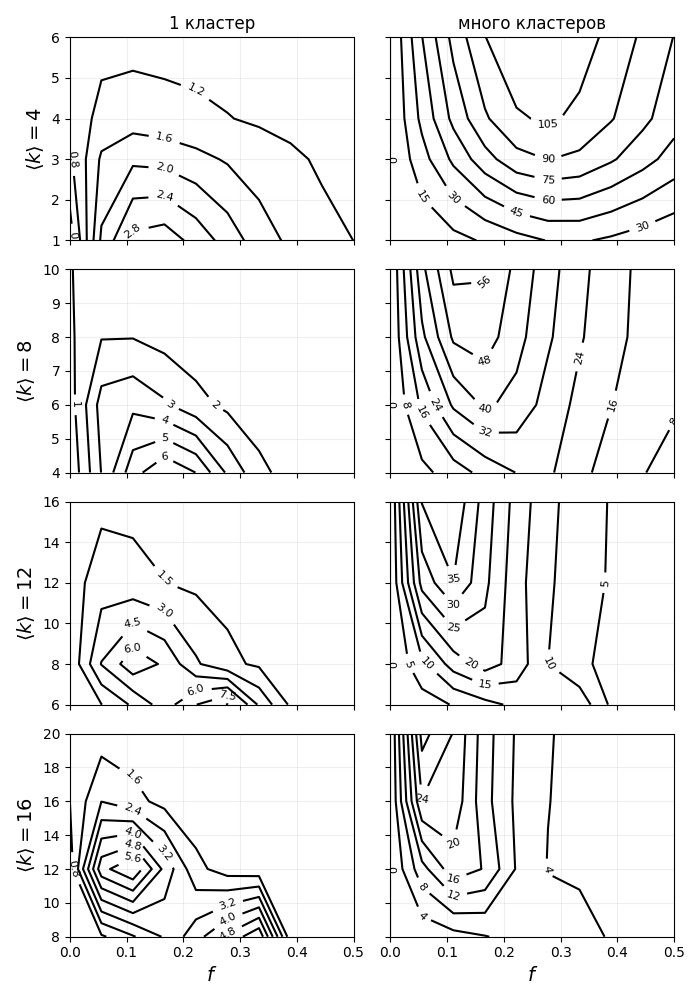

In [15]:


all_data = (
    (k4_data, k4_data_noncom),
    (k8_data, k8_data_noncom),
    (k12_data, k12_data_noncom),
    (k16_data, k16_data_noncom),
)

plt.close('contour')
fig, axs = plt.subplots(4, 2, figsize=(7, 10), num='contour', sharey='row', sharex=True)

for data, ax, k in zip(all_data, axs, [4, 8, 12, 16]):
    compact_data = data[0].loc[data[1].index.unique()].pivot_table('n_minus_components_mean', index='sug', columns='f')
    noncompact_data = data[1].pivot_table('n_minus_components_mean', index='sug', columns='f')
    plot_contours(compact_data, noncompact_data, *ax, 'black')

    ax[0].set_ylabel(f'$\\langle k\\rangle={k}$')

axs[0, 0].set_title('1 кластер')
axs[0, 1].set_title('много кластеров')

axs[-1, 0].set_xlabel('$f$')
axs[-1, 1].set_xlabel('$f$')
axs[-1, 0].set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])

plt.tight_layout()
plt.savefig('figures/compact/compact_vs_noncompact.png')

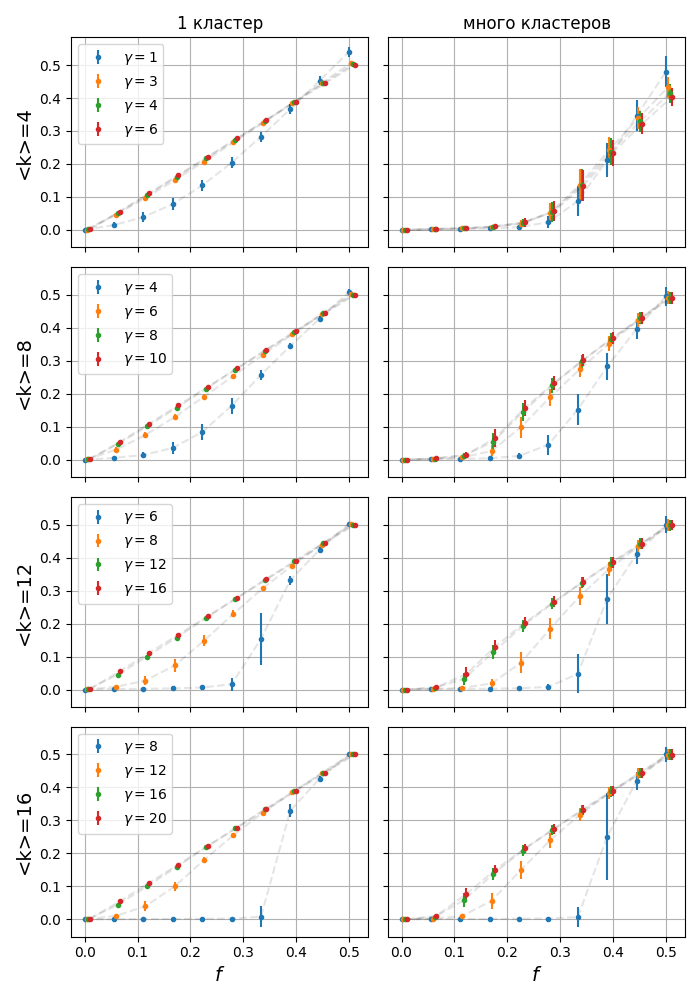

In [14]:
fig, axs = plt.subplots(4, 2, figsize=(7, 10), sharey=True, sharex=True)

COLUMN = 's1'
MEAN_COLUMN = COLUMN + '_mean'
STD_COLUMN = COLUMN + '_std'


for ax, data, k in zip(axs, all_data, [4, 8, 12, 16]):
    
    for i, suggestability in enumerate(data[1].index.unique()):
        r1 = data[0].loc[suggestability]
        ax[0].plot(r1.f + i * 35e-4, r1[MEAN_COLUMN], 'k--', alpha=0.1)
        ax[0].errorbar(r1.f + i * 35e-4, r1[MEAN_COLUMN], yerr=r1[STD_COLUMN], fmt='.', label=f'$\gamma={suggestability}$')
        r1 = data[1].loc[suggestability]
        ax[1].plot(r1.f + i * 35e-4, r1[MEAN_COLUMN], 'k--', alpha=0.1)
        ax[1].errorbar(r1.f + i * 35e-4, r1[MEAN_COLUMN], yerr=r1[STD_COLUMN], fmt='.', label=f'$\gamma={suggestability}$')
    
    ax[0].set_ylabel(f'<k>={k}')
    ax[0].legend()
    ax[0].grid(True)
    ax[1].grid(True)

axs[0, 0].set_title('1 кластер')
axs[0, 1].set_title('много кластеров')
axs[-1, 0].set_xlabel('$f$')
axs[-1, 1].set_xlabel('$f$')
plt.tight_layout()
plt.savefig(f'figures/compact/{COLUMN}_v_sf.png')

In [59]:
axs

array([[<Axes: ylabel='<k>=4'>, <Axes: >],
       [<Axes: ylabel='<k>=8'>, <Axes: >],
       [<Axes: ylabel='<k>=12'>, <Axes: >],
       [<Axes: ylabel='<k>=16'>, <Axes: >]], dtype=object)

# Разная убеждаемость

In [32]:
# k8_suggest = load_data('data/compact_erd_ren_k8_n2000_diff_suggest/')
# k12_suggest = load_data('data/compact_erd_ren_k12_n2000_diff_suggest/')
k8_suggest_compact = load_data('data/diff-suggest/compact_erd_ren_k8_n2000_diff_suggest/')
k12_suggest_compact = load_data('data/diff-suggest/compact_erd_ren_k12_n2000_diff_suggest/')

<a list of 8 text.Text objects>

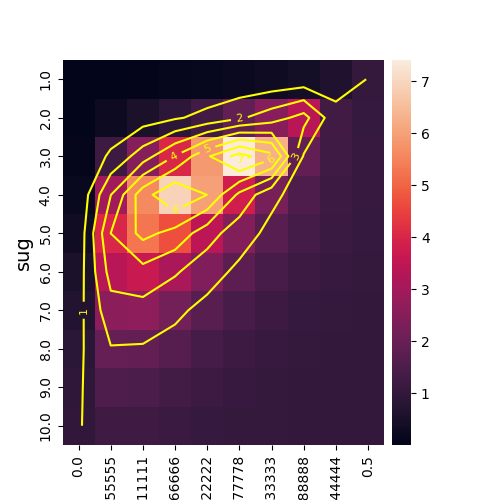

In [53]:
k8_components_data = k8_suggest_compact.pivot_table('n_minus_components_mean', index='sug', columns='f')

plt.close('contour')
fig, ax = plt.subplots(figsize=(5, 5), num='contour')
sns.heatmap(data=k8_components_data, cbar_kws={'pad': 0.02}, ax=ax)
contours = ax.contour(
    np.arange(0.5, k8_components_data.values.shape[1]),
    np.arange(0.5, k8_components_data.values.shape[0]),
    k8_components_data.values,
    colors='yellow'
)
plt.clabel(contours, inline=True, fontsize=8)
# plt.show()
# fig, (ax1, ax2) = plt.subplots(1, 2, num='contour')
# contour = ax1.contour(
#     k8_components_data.columns.values,
#     k8_components_data.index.values,
#     k8_components_data.values,
#     20,
#     cmap='RdGy'
# )
# cbar = fig.colorbar(contour)
# sns.heatmap(k8_components_data, ax=ax)

In [48]:
k8_components_data

f     0.000000  0.055556  0.111111  0.166667  0.222222  0.277778  0.333333  \
sug                                                                          
1.0     0.0045    0.0275    0.0540    0.1010    0.1435    0.1920    0.2815   
2.0     0.0185    0.2445    0.5445    0.8910    1.2865    1.8635    2.5295   
3.0     0.0680    1.1715    2.5095    4.0485    5.8690    7.4050    6.2995   
4.0     0.1700    2.9785    5.5950    6.9350    5.9880    3.7680    2.2410   
5.0     0.3305    4.0035    5.2850    4.6675    3.4215    2.4380    1.7370   
6.0     0.5340    3.3760    3.6745    3.1115    2.3940    1.7920    1.3985   
7.0     0.6965    2.6100    2.6460    2.1925    1.7265    1.4150    1.1870   
8.0     0.8195    1.9430    1.9060    1.6710    1.3575    1.1890    1.0800   
9.0     0.9215    1.5180    1.4660    1.3165    1.1840    1.0890    1.0295   
10.0    0.9715    1.2405    1.2225    1.1445    1.0685    1.0290    1.0170   

f     0.388889  0.444444  0.500000  
sug                                 
1.0     0.3815    0.6140    1.0245  
2.0     3.3610    1.2780    1.0605  
3.0     1.9105    1.2670    1.0935  
4.0     1.5350    1.2155    1.0790  
5.0     1.3420    1.1355    1.0505  
6.0     1.1735    1.0760    1.0235  
7.0     1.0720    1.0260    1.0070  
8.0     1.0315    1.0125    1.0030  
9.0     1.0100    1.0040    1.0010  
10.0    1.0045    1.0005    1.0005

In [4]:
k12_suggest.columns

Index(['f', 'fraction_mean', 'fraction_std', 'n_minus_components_mean',
       'n_minus_components_std', 's1_mean', 's1_std', 's2_mean', 's2_std',
       's1_persistence_mean', 's1_persistence_std', 's2_persistence_mean',
       's2_persistence_std', 's1_change_op_mean', 's1_change_op_std',
       's2_change_op_mean', 's2_change_op_std'],
      dtype='object')

In [150]:
measurments = [
    'fraction',
    's2',
    's1_persistence',
    'n_minus_components',
]

labels = [
    '$fraction$',
    '$s_2$',
    '$s_1$ persistence',
    '$\#\sigma_-$ кластеров'
]

In [31]:
len(k8_data)

0

In [33]:
k8_data = []
k12_data = []

for measure in measurments:
    k8_data.append(k8_suggest_compact.pivot_table(measure + '_mean', index='f', columns='sug'))
    k12_data.append(k12_suggest_compact.pivot_table(measure + '_mean', index='f', columns='sug'))

In [85]:
def set_share_axes(axs, target=None, sharex=False, sharey=False):
    if target is None:
        target = axs.flat[0]
    # Manage share using grouper objects
    for ax in axs.flat:
        if sharex:
            target._shared_axes['x'].join(target, ax)
        if sharey:
            target._shared_axes['y'].join(target, ax)
    # Turn off x tick labels and offset text for all but the bottom row
    if sharex and axs.ndim > 1:
        for ax in axs[:-1,:].flat:
            ax.xaxis.set_tick_params(which='both', labelbottom=False, labeltop=False)
            ax.xaxis.offsetText.set_visible(False)
    # Turn off y tick labels and offset text for all but the left most column
    if sharey and axs.ndim > 1:
        for ax in axs[:,1:].flat:
            ax.yaxis.set_tick_params(which='both', labelleft=False, labelright=False)
            ax.yaxis.offsetText.set_visible(False)

In [152]:
3 * size, size / height_ratios[1] * sum(height_ratios)

(9, 6.375)

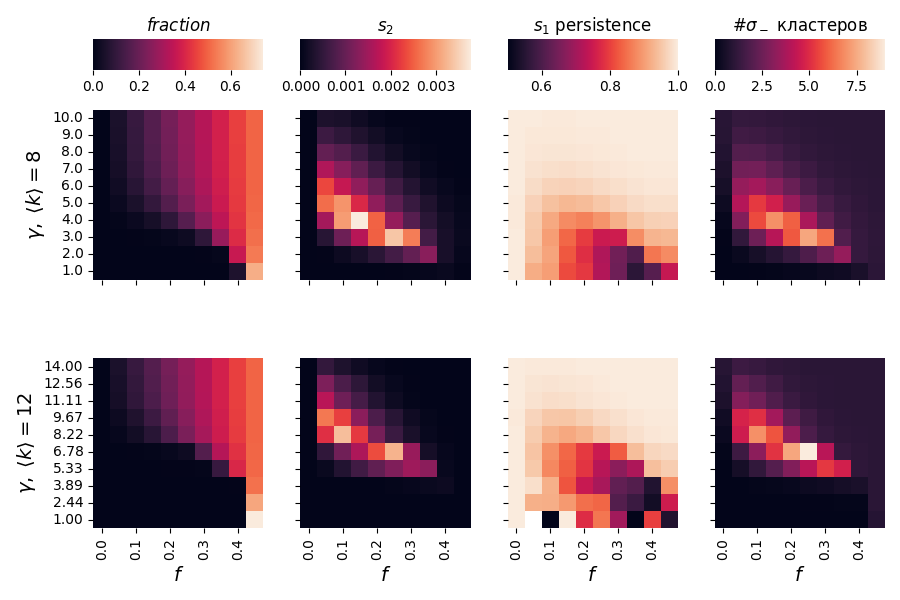

In [159]:
size = 3
height_ratios=(1, 8, 8)
fig, axs = plt.subplots(
    3,
    len(measurments),
    height_ratios=height_ratios, sharey='row',
    tight_layout=True,
    figsize=(9, 6)
)

for (cbar, k8_ax, k12_ax), (k8_d, k12_d), label in zip(axs.T, zip(k8_data, k12_data), labels):
    mn = min(k8_d.min(axis=None), k12_d.min(axis=None))
    mx = max(k8_d.max(axis=None), k12_d.max(axis=None))
    sns.heatmap(k12_d.T, vmin=mn, vmax=mx, square=True, ax=k12_ax, cbar_ax=cbar, cbar_kws={"orientation": "horizontal"})
    sns.heatmap(k8_d.T, vmin=mn, vmax=mx, square=True, ax=k8_ax, cbar=False)
    cbar.set_title(label)
    k8_ylabels = list(map(lambda t: f'{float(t.get_text()):.2f}', k8_ax.yaxis.get_ticklabels()))
    k12_ylabels = list(map(lambda t: f'{float(t.get_text()):.2f}', k12_ax.yaxis.get_ticklabels()))
    k8_xlabels = list(map(lambda t: f'{float(t.get_text()):.1f}', k8_ax.xaxis.get_ticklabels()))
    k12_xlabels = list(map(lambda t: f'{float(t.get_text()):.1f}', k12_ax.xaxis.get_ticklabels()))
    k8_ax.xaxis.set_ticklabels(k8_xlabels)
    k12_ax.xaxis.set_ticklabels(k12_xlabels)
    k8_ax.invert_yaxis()
    k12_ax.invert_yaxis()
    k8_ax.xaxis.set_label_text('')
    k8_ax.yaxis.set_label_text('')
    k12_ax.xaxis.set_label_text('$f$')
    k12_ax.yaxis.set_label_text('')

# for ax in axs[0, 1:]:
#     axs[0, 0].sharex(ax)


set_share_axes(axs[1:, :], sharex=True)
# set_share_axes(axs[0, :], sharey=True)
# set_share_axes(axs[1, :], sharey=True)

k8_ylabels = list(map(lambda t: f'{float(t.get_text()):.1f}', axs[1, 0].yaxis.get_ticklabels()))
k12_ylabels = list(map(lambda t: f'{float(t.get_text()):.2f}', axs[2, 0].yaxis.get_ticklabels()))
k8_xlabels = list(map(lambda t: f'{float(t.get_text()):.1f}', axs[1, 0].xaxis.get_ticklabels()))
k12_xlabels = list(map(lambda t: f'{float(t.get_text()):.1f}', axs[2, 0].xaxis.get_ticklabels()))
axs[1, 0].yaxis.set_label_text(r'$\gamma,\;\langle k\rangle=8$')
axs[1, 0].yaxis.set_ticklabels(k8_ylabels)
# for ax in axs[0]:
#     ax.set_xticklabels(k8_xlabels)
axs[2, 0].yaxis.set_label_text(r'$\gamma,\;\langle k\rangle=12$')
_ = axs[2, 0].yaxis.set_ticklabels(k12_ylabels)
plt.savefig('figures/heatmap_k812.png')


In [123]:
(3 * size, size / height_ratios[0] * sum(height_ratios))

(12, 8.5)

In [59]:
axs[0, 0].yaxis.get_ticklabels()

[Text(0, 0.5, '1.0'),
 Text(0, 1.5, '2.0'),
 Text(0, 2.5, '3.0'),
 Text(0, 3.5, '4.0'),
 Text(0, 4.5, '5.0'),
 Text(0, 5.5, '6.0'),
 Text(0, 6.5, '7.0'),
 Text(0, 7.5, '8.0'),
 Text(0, 8.5, '9.0'),
 Text(0, 9.5, '10.0')]

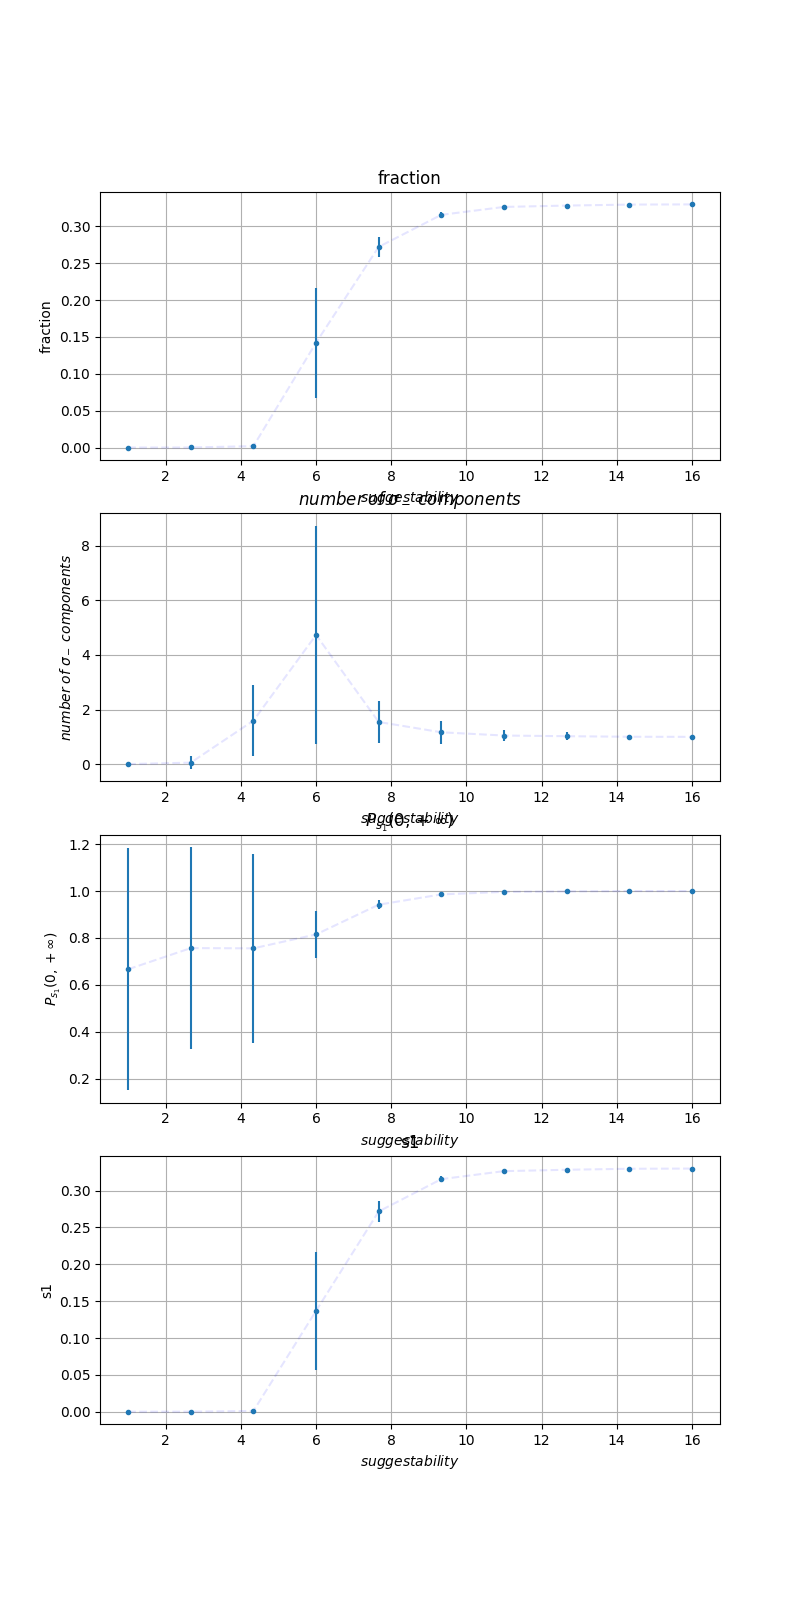

In [28]:
fig, axs = plt.subplots(4, 1, figsize=(8, 16))

columns = ['fraction', 'n_minus_components', 's1_persistence', 's1']
labels = ['fraction', '$number\; of\; \sigma_-\; components$', '$P_{s_1}(0, +\infty)$', 's1']
COLUMN = 's1_persistence'
MEAN_COLUMN = COLUMN + '_mean'
STD_COLUMN = COLUMN + '_std'

sgt = k12_suggest.index.values

for ax, col, name in zip(axs, columns, labels):
    ax.set_title(name)
    y = k12_suggest[col + '_mean']
    y_std = k12_suggest[col + '_std']
    ax.plot(sgt, y, 'b--', alpha=0.1)
    ax.errorbar(sgt, y, yerr=y_std, fmt='.')
    ax.set_xlabel('$suggestability$')
    ax.set_ylabel(name, rotation=90)
    ax.grid(True)
plt.show()

<Axes: >